In [ ]:
# testing all sessions before figuring out what half the sample of electrodes is by 
# going through whole program and logging errors. then will manually check thoseh not loading 2020-06-12

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
HPC_labels = [MTL_labels[i] for i in [0,1,2,3,4,8,9,10,11,12,20,24,25]] # all labels within HPC
ENT_labels = [MTL_labels[i] for i in [6,14,22,26,28]] # all labels within entorhinal
exp = 'FR1'
poss_subs = df[df.experiment == exp]

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):


In [2]:
# sub lists I've been using for sample code

# subs = ['R1002P','R1003P','R1006P','R1010J','R1112M','R1163T'] # initial 6 for hippocampus
# subs = subs+['R1001P','R1092J','R1151E','R1320D'] # additional subs with issues that I resolved with various RR and corr thresholds
# subs = ['R1112M','R1018P','R1020J','R1022J','R1023J','R1026D','R1027J'] # 7 with entorhinal
subs = ['R1010J','R1112M'] # original 2
# subs = ['R1112M','R1163T'] #'R1112M' # subjects with FR1 and catFR1. SRs of 1000 and 500 tho
# subs = ['R1151E'] # all channels X sessions get removed but 3 after 60/180 hz line removal
# remaining subs with issues (see SWR_exception_log)
subs = ['R1163T','R1186P','R1221P','R1212P'] # all fixed! see ClusterRunSWR_log_FIXES.txt
# subs = ['R1345D'] # electrode cats blank
bad_subs = ['R1433E'] # no electrode cats

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
# sub_df = sub_df[2:3]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
924,NaN,protocols/r1/subjects/R1163T/experiments/FR1/s...,protocols/r1/subjects/R1163T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1163T/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1163T/localizations/0/m...,NaN,0,R1163T,R1163T,NaN,protocols/r1/subjects/R1163T/experiments/FR1/s...
925,NaN,protocols/r1/subjects/R1163T/experiments/FR1/s...,protocols/r1/subjects/R1163T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1163T/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1163T/localizations/0/m...,NaN,1,R1163T,R1163T,NaN,protocols/r1/subjects/R1163T/experiments/FR1/s...
1056,NaN,protocols/r1/subjects/R1186P/experiments/FR1/s...,protocols/r1/subjects/R1186P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1186P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1186P/localizations/0/m...,NaN,0,R1186P,R1186P,NaN,protocols/r1/subjects/R1186P/experiments/FR1/s...
1199,NaN,protocols/r1/subjects/R1212P/experiments/FR1/s...,protocols/r1/subjects/R1212P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1212P/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1212P/localizations/0/m...,NaN,10,R1212P,R1212P,1.0,protocols/r1/subjects/R1212P/experiments/FR1/s...
1200,NaN,protocols/r1/subjects/R1212P/experiments/FR1/s...,protocols/r1/subjects/R1212P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1212P/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1212P/localizations/0/m...,NaN,2,R1212P,R1212P,1.0,protocols/r1/subjects/R1212P/experiments/FR1/s...
1237,NaN,protocols/r1/subjects/R1221P/experiments/FR1/s...,protocols/r1/subjects/R1221P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1221P/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1221P/localizations/0/m...,NaN,1,R1221P,R1221P,1.0,protocols/r1/subjects/R1221P/experiments/FR1/s...


In [3]:
# 575 FR sessions. 17 of them don't load up to 
exp_df = df[df.experiment==exp]
exp_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
0,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,0,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
1,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,1,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
9,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,0,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
10,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,1,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
17,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,0,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,NaN,protocols/r1/subjects/R1462M/experiments/FR1/s...,protocols/r1/subjects/R1462M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1462M/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1462M/localizations/0/m...,NaN,0,R1462M,R1462M,3.4,protocols/r1/subjects/R1462M/experiments/FR1/s...
2149,NaN,protocols/r1/subjects/R1463E/experiments/FR1/s...,protocols/r1/subjects/R1463E/localizations/1/m...,FR1,build,1,protocols/r1/subjects/R1463E/experiments/FR1/s...,1,NaN,0,protocols/r1/subjects/R1463E/localizations/1/m...,NaN,0,R1463E,R1463E_1,3.4,protocols/r1/subjects/R1463E/experiments/FR1/s...
2150,NaN,protocols/r1/subjects/R1463E/experiments/FR1/s...,protocols/r1/subjects/R1463E/localizations/1/m...,FR1,build,1,protocols/r1/subjects/R1463E/experiments/FR1/s...,1,NaN,1,protocols/r1/subjects/R1463E/localizations/1/m...,NaN,1,R1463E,R1463E_1,3.4,protocols/r1/subjects/R1463E/experiments/FR1/s...
2164,NaN,protocols/r1/subjects/R1466J/experiments/FR1/s...,protocols/r1/subjects/R1466J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1466J/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1466J/localizations/0/m...,NaN,0,R1466J,R1466J,3.4,protocols/r1/subjects/R1466J/experiments/FR1/s...


## CLUSTER get SWRs after removing IEDs!

In [5]:
def ClusterRunSWRs(param):

    import pandas as pd
    import numpy as np
    import os
    import sys; sys.path.append('/home1/john/johnModules')
    import dill, pickle
    import mne
    from scipy.signal import firwin,filtfilt,kaiserord
    from ptsa.data.filters import ButterworthFilter
    from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
    %load_ext autoreload
    %autoreload
    from SWRmodule import CMLReadDFRow,get_bp_tal_struct,get_elec_regions,ptsa_to_mne
    from SWRmodule import detectRipplesHamming
    from general import superVstack
    from SWRmodule import downsampleBinary,LogDFExceptionLine,getBadChannels,getStartEndArrays
    import pingouin as pg
    HPC_labels = [MTL_labels[i] for i in [0,1,2,3,4,8,9,10,11,12,20,24,25]] # all labels within HPC
    ENT_labels = [MTL_labels[i] for i in [6,14,22,26,28]] # all labels within entorhinal

    ### PARAMS ###

    save_values = 1

    selected_period = 'surrounding_recall' # surrounding_recall # whole_retrieval # encoding 
    # there are three periods this code is set up to look at: periods aligned to recall, the entire retrieval period, and the encoding period

    remove_soz_ictal = False # False only removes bad electrodes and not soz/ictal
    min_ripple_rate = 0.1 # Hz.
    max_ripple_rate = 2.0 # Hz.
    max_trial_by_trial_correlation = 0.05 # if ripples correlated more than this remove them
    max_electrode_by_electrode_correlation = 0.2 #???
    
    selected_region = HPC_labels #HPC_labels #HPC_labels # ENT_labels+HPC_labels 

    # recall params
    IRI = 2000 # inter-ripple interval...remove ripples within this range (keep only first one and remove those after it)
    retrieval_whole_time = 30000
    # encoding params
    encoding_time = 2000 # actual preentation is 1.6 s + 0.75-1.0 s so just keep 2.0 s of data for PSTH
    pre_encoding_time = -500 # since minimum ISI is 0.75 s let's only plot the 500 ms before word on
    # these aren't likely to be changed:
    desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.
    filter_type = 'hamming' # see local version below for details. 'butter' is removed from cluster version so don't change this
    
    ### END PARAMS ###

    if 'entorhinal' in selected_region and 'left hippocampus' in selected_region:
        region_name = 'HPC_ENT' # these just get names for file save at bottom
    elif 'entorhinal' in selected_region:
        region_name = 'ENT'
    elif 'left hippocampus' in selected_region:
        region_name = 'HPC'
    if selected_period == 'surrounding_recall':
        psth_start = -IRI # only makes sense to look at period <= IRI
        psth_end = IRI # how long to grab data after recall
    elif selected_period == 'whole_retrieval':
        psth_start = -IRI # doesn't have to be IRI just 2000 ms is convenient
        psth_end = IRI+retrieval_whole_time
    elif selected_period == 'encoding':
        psth_start = pre_encoding_time
        psth_end = encoding_time

    ripple_array = []; fr_array = []; 
    trial_nums = []; encoded_word_key_array = []
    HPC_names = []; sub_sess_names = []; sub_names = []
    electrodes_per_session = []
    total_lists = 0; total_recalls = 0; kept_recalls = 0
    ent_elec_ct = []; sd_regions = []; not_sd_regions = []
    ripple_ied_accum_ct = []
    time_add_save = []
    
    trial_by_trial_correlation = []; elec_by_elec_correlation = []
    session_ripple_rate_by_elec = []; elec_ripple_rate_array = []

    program_ran = 0
    try:
        with open('temp_dfSWR.p', 'rb') as f: ### change here to avoid overwrite
            temp_df = dill.load(f)   
        row = temp_df[param]
        sub = row.subject; session = row.session; exp = row.experiment
        mont = int(row.montage); loc = int(row.localization)
        reader = CMLReadDFRow(row)
        evs = reader.load('task_events')
        evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)] # recalled word AND correct (in previous list)
        # remove events with Inter-Recall Intervals too small. Use psth_start for IRI since that's what will show in PSTH
        evs_free_recall = evs_free_recall[np.append(True,np.diff(evs_free_recall.mstime)>IRI)] 
        
        pairs = reader.load('pairs')
        tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
        elec_regions,atlas_type = get_elec_regions(tal_struct) 

        # load eeg
        if selected_period == 'surrounding_recall':
            total_recalls = total_recalls + len(evs_free_recall) # get total recalls from lists
            total_lists = total_lists + len(evs[evs.type=='WORD'].list.unique()) # get total lists
            kept_recalls = kept_recalls + len(evs_free_recall)
            eeg_events = evs_free_recall
        elif selected_period == 'whole_retrieval':
            # grab whole retrieval periods for a better baseline of SWRs
            evs_rets = evs[evs.type=='REC_START']
            eeg_events = evs_rets
        elif selected_period == 'encoding':
            # I'm going to save encoding word events too, but need a mask to keep track of:
            # 0) words not recalled 1) words recalled from this list 2) words later recalled BUT IRI<2 s so removed
            evs_encoding_words = evs[evs.type=='WORD']
            encoded_word_key = np.zeros(len(evs_encoding_words)) # 0 for not recalled
            encoded_word_key[evs_encoding_words.recalled==True] = 2 # 2 for recalled but removed bc IRI<2 s
            encoded_word_key[evs_encoding_words.item_name.isin(evs_free_recall.item_name.unique())] = 1 # recalled words
            # since finding all encoding words IN the list of correctly free recalled words won't have any intrusions
            eeg_events = evs_encoding_words

        eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start, rel_stop=psth_end, clean=True, scheme=pairs)
        # events X electrodes X time
        sr = eeg.samplerate

        # if weird samplerate, add a few ms to make the load work
        if (499<sr<500) | (998<sr<1000):
            time_add = 1
            if (499<sr<500):
                sr = 500
            elif (998<sr<1000):
                sr = 1000
            while eeg.shape[2] < (psth_end-psth_start)/(1000/sr):
                eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start, rel_stop=psth_end+time_add, clean=True, scheme=pairs)
                if time_add>50:
                    break
                time_add+=1
            time_add_save.append(time_add)

        eeg_ptsa = eeg.to_ptsa()
        
        # line removal...don't do 120 for now
        eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
        eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[178.,182.], filt_type='stop', order=4).filter()

        ## FILTERS ##
        trans_width = 5.
        ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(sr/trans_width) # gives 400 with sr=500, trans=5
        FIR_bandstop = firwin(int(ntaps+1), [70.,178.], fs=sr, window='hamming',pass_zero='bandstop')
    #     FIR_bandpass = firwin(int(ntaps), [70.,180.], fs=sr, window='hamming',pass_zero='bandpass')
        bandstop_25_60 = firwin(int(ntaps+1), [20.,58.], fs=sr, window='hamming',pass_zero='bandstop') # Norman 2019 IED
    #     bandstop_60_80 = firwin(int(ntaps+1), [60.,80.], fs=sr, window='hamming',pass_zero='bandstop') # Gelinas 2016 IED
        nyquist = sr/2
        ntaps40, beta40 = kaiserord(40, trans_width/nyquist)
        kaiser_40lp_filter = firwin(ntaps40, cutoff=40, window=('kaiser', beta40), scale=False, nyq=nyquist, pass_zero='lowpass')

        # filter for ripples using filter selected above
        if filter_type == 'hamming':
            # need to subtract out to get the filtered signal since default is bandstop but want to keep it as PTSA        
            eeg_rip_band = eeg_ptsa-filtfilt(FIR_bandstop,1.,eeg_ptsa) 
            #         eeg_rip_band = filtfilt(FIR_bandpass,1.,eeg_ptsa) # can't use ptsa_to_mne this way so use eeg-bandstopped signal
            eeg_ied_band = eeg_ptsa-filtfilt(bandstop_25_60,1.,eeg_ptsa)     

        eeg_rip_band = ptsa_to_mne(eeg_rip_band,[0,psth_end-psth_start])
        _ = eeg_rip_band.apply_hilbert(envelope=True)
        eeg_ied_band = ptsa_to_mne(eeg_ied_band,[0,psth_end-psth_start])
        _ = eeg_ied_band.apply_hilbert(envelope=True)
        
        # get bad channel mask
        try:
            elec_cats = reader.load('electrode_categories') # this is cool
        except:
            e = 'No electrode categories for '+sub+', session '+str(session)
            LogDFExceptionLine(row, e, 'SWR_no_elec_cats_log_Test.txt')
            #continue
        bad_bp_mask = getBadChannels(tal_struct,elec_cats,remove_soz_ictal)
        
        region_electrode_ct = 0
        for channel in range(len(elec_regions)):
            if (elec_regions[channel] in selected_region) & \
            (bad_bp_mask[channel] == 0): # don't use bad electrodes

                # get data from MNE container
                eeg_rip = eeg_rip_band.get_data()[:,channel,:]     
                eeg_ied = eeg_ied_band.get_data()[:,channel,:]

                # select detection algorithm (note that iedlogic is same for both so always run that)

                if filter_type == 'hamming':
                    # filter IEDs 
                    eeg_ied = eeg_ied**2 # already rectified now square
                    eeg_ied = filtfilt(kaiser_40lp_filter,1.,eeg_ied) # low pass filter  
                    mean1 = np.mean(eeg_ied)
                    std1 = np.std(eeg_ied)
                    iedlogic = eeg_ied>=mean1+4*std1 # Norman et al 2016                
                    # detect ripples
                    ripplelogic = detectRipplesHamming(eeg_rip,trans_width,sr,iedlogic)             

                if sr>desired_sample_rate: # downsampling here for anything greater than 500
                    # but can fix that in the future if necessary (maybe can FFT resample?)
                    ripplelogic = downsampleBinary(ripplelogic,sr/desired_sample_rate)
    #                 iedlogic = downsampleBinary(iedlogic,sr/desired_sample_rate)
    
                # skip this electrode if the ripple rate is below threshold
                temp_start_array,_ = getStartEndArrays(ripplelogic,sr)
                elec_ripple_rate = np.sum(temp_start_array)/temp_start_array.shape[0]/((psth_end-psth_start)/1000)
                if elec_ripple_rate < min_ripple_rate:
#                     print(sub+', '+str(session)+' skipped b/c below ripple rate thresh for ch.: '+str(channel))
                    continue
                elif elec_ripple_rate > max_ripple_rate:
#                     print(sub+', '+str(session)+' skipped b/c ABOVE ripple rate thresh for ch.: '+str(channel))
                    continue # skip this electrode

                # check the ripples for this electrode and make sure they're not super correlated across trials

                # first, bin the array so can get more realistic correlation not dependent on ms timing
                binned_ripplelogic = downsampleBinary(ripplelogic,10) # downsample by 10x so 10 ms bins
                trial_ripple_df = pd.DataFrame(data=np.transpose(binned_ripplelogic))
                num_cols = len(list(trial_ripple_df))
                trial_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
                temp_tbt_corr = np.mean(pg.pairwise_corr(trial_ripple_df,method='spearman').r)
#                 if temp_tbt_corr > max_trial_by_trial_correlation:
# #                     print(sub+', '+str(session)+' skipped b/c above trial-by-trial correlation for ch.: '+str(channel))
#                     continue
    
                ## if this electrode passes SAVE data ##
        
                trial_by_trial_correlation.append(temp_tbt_corr) # corr b/w trials
                elec_ripple_rate_array.append(elec_ripple_rate) # record the average ripple rate for this electrode 

                # append arrays across electrodes
                ripple_array = superVstack(ripple_array,ripplelogic) # append across electrodes
                session_ripple_rate_by_elec = superVstack(session_ripple_rate_by_elec,np.mean(binned_ripplelogic,0)) # for correlation b/w elecs below
                
                # get other info
                if selected_period == 'encoding':
                    encoded_word_key_array.append(encoded_word_key) # save the key for each electrode so easier to unpack later

                if selected_period == 'whole_retrieval':
                    # make a matrix of the times of free recall if looking at whole retrieval period
                    list_nums = evs_rets.list.unique()
                    temp_fr_array = np.zeros((len(list_nums),retrieval_whole_time))
                    for ln in list_nums:
                        list_times = evs_free_recall[evs_free_recall.list==ln].rectime # I confirmed these are accurate relative to REC_START
                        temp_fr_array[ln-1][np.array(list_times)] = 1            
                    fr_array = superVstack(fr_array,temp_fr_array)

                trial_nums = np.append(trial_nums,ripplelogic.shape[0])
                region_electrode_ct+=1 # channel ct for this session
                HPC_names.append(elec_regions[channel])
                sub_sess_names.append(sub+'-'+str(session))
                sub_names.append(sub)
        
        program_ran = 1          
        # before we keep all the electrodes in this session, remove electrodes that are highly correlated.
        # this really only makes sense for the cluster version, since I only do a session at a time here
        if np.sum(session_ripple_rate_by_elec)>0 and region_electrode_ct>1:
            session_ripple_df = pd.DataFrame(data=np.transpose(session_ripple_rate_by_elec))
            num_cols = len(list(session_ripple_df))
            session_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
            elec_by_elec_correlation = np.mean(pg.pairwise_corr(session_ripple_df,method='spearman').r) # correlation b/w elecs 
#             if elec_by_elec_correlation > max_electrode_by_electrode_correlation:
#                 e = sub+', '+str(session)+' had correlation over '+str(max_electrode_by_electrode_correlation)+' b/w electrodes so skipped'
#                 LogDFExceptionLine(row, e, 'ClusterRunSWR_log_TEST.txt')
#                 program_ran = 0

    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterRunSWR_exception_log_Test.txt') #np.save('SWRscript_FR1.npy', ['Exception', str(e.__class__), str(e)])
        #continue

    if save_values == 1 and program_ran == 1:
        if remove_soz_ictal == False:
            soz_label = 'soz_in'
        else:
            soz_label = 'soz_out'
        fn = os.path.join('/scratch/john/SWR_scratch/',
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+'_'+soz_label+'.p')            
        with open(fn,'wb') as f:
            pickle.dump({'region_electrode_ct':region_electrode_ct, 
                        'HPC_names':HPC_names, 'sub_sess_names':sub_sess_names,
                        'ripple_array':ripple_array, 'time_add_save':time_add_save,
                        'trial_nums':trial_nums, 'encoded_word_key_array':encoded_word_key_array,
                        'fr_array':fr_array, 'sub_names':sub_names,
                        'total_recalls':total_recalls, 'kept_recalls':kept_recalls,
                        'trial_by_trial_correlation':trial_by_trial_correlation, # one value for each electrode for this session
                        'elec_by_elec_correlation':elec_by_elec_correlation,
                        'elec_ripple_rate_array':elec_ripple_rate_array}, f)

os.chdir('/home1/john/SWR/cluster') # where temp files will go

# save as dill so can bypass pickling in ipython for cluster parallelization
import dill
temp_df = list(exp_df.itertuples())
with open('temp_dfSWR.p', 'wb') as f: 
    dill.dump(temp_df,f)
params = []
for i in range(len(temp_df)):
    params.append(i)

ClusterRun(ClusterRunSWRs, params)

print('finished ClusterRunSWRs!!')

100 Engines running
Sending a shutdown signal to the controller and engines.
Manual shutdown of cluster failed, often this is because the cluster was already shutdown.


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

finished ClusterRunSWRs!!


In [6]:
fileDeleter("/home1/john/SWR/cluster/","sge_engine")
fileDeleter("/home1/john/SWR/cluster/","sge_controller")
fileDeleter("/home1/john/SWR/cluster/","bcbio-")

finished ClusterRunSWRs!!


## Load CLUSTER data

In [222]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used
selected_period = 'surrounding_recall' # surrounding_recall # whole_retrieval # encoding 
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC 
remove_soz_ictal = False
###

if remove_soz_ictal == False:
    soz_label = 'soz_in'
else:
    soz_label = 'soz_out'
ripple_array = []; 
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []

for row in sub_df.itertuples(): #sub_df.itertuples():   
    try:
        sub = row.subject; session = row.session; exp = row.experiment
        fn = os.path.join('/scratch/john/SWR_scratch/',
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+'_'+soz_label+'.p') 
        with open(fn,'rb') as f:
            dat = pickle.load(f)
            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.append(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            #'fr_array':fr_array,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
        
    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')
        
# some info on data loaded from cluster runs
ripple_array.shape
region_electrode_ct
'Total electrodes: '+str(sum(region_electrode_ct))
np.array(encoded_word_key_array)
np.array(HPC_names)
len(trial_nums)
trial_nums
np.sum(trial_nums)
np.array(sub_sess_names)
len(sub_sess_names)
len(sub_names)

(110, 2000)

[2, 0, 1]

'Total electrodes: 3'

array([], shape=(3, 0), dtype=float64)

array(['left dg', 'left ca1', 'left ca1'], dtype='<U8')

3

array([47., 47., 16.])

110.0

array(['R1151E-0', 'R1151E-0', 'R1151E-2'], dtype='<U8')

3

3

## LOCAL run (original program)

In [242]:
import mne
from scipy.signal import firwin,filtfilt,kaiserord
import pingouin as pg
%autoreload

### PARAMS ###

save_values = 0 

selected_period = 'surrounding_recall' # surrounding_recall # whole_retrieval # encoding 
# there are three periods this code is set up to look at: periods aligned to recall, the entire retrieval period, and the encoding period

selected_region = HPC_labels #HPC_labels # ENT_labels+HPC_labels 

remove_soz_ictal = False # False only removes bad electrodes and not soz/ictal
min_ripple_rate = 0.1 # Hz.
max_ripple_rate = 2.0 # Hz.
max_trial_by_trial_correlation = 0.05 # if ripples correlated more than this remove them
max_electrode_by_electrode_correlation = 0.2 #???

filter_type = 'hamming' # 'butter' # Vaz used Butterworth from 80-120 Hz; Norman used Hamming from 70-180 Hz
# •Butterworth from Vaz et al: 2nd order from 80-120 ms, hilbert, select events >2 STD above mean of filtered traces.
#      Events >=25 ms long w/ max amp >3 SD were retained as ripples. Join adjacent ripples separated by <15 ms 
# •Hilbert from Norman et al: "70-180 Hz zero-lag linear-phase Hamming FIR filter w/ transition bandwidth of 5 Hz"
#      Then Hilbert, clip extreme to 4 SD, square this clipped, smooth w/ Kaiser FIR low-pass filter with 40 Hz cutoff,
#      mean and SD computed across entire experimental duration to define the threshold for event detection
#      Events from original (squared but unclipped) signal >4 SD above baseline were selected as candidate SWR events. 
#      Duration expanded until ripple power <2 SD. Events <20 ms or >200 ms excluded. Adjacent events <30 ms separation (peak-to-peak) merged.
# •Using IED detection from Vaz for 250 Hz highpass events (really 250-499). Norman uses 20-60 Hz events which is...odd.
#       See detectRipples code in module for this algorithm


# recall params
IRI = 2000 # inter-ripple interval...remove ripples within this range (keep only first one and remove those after it)
retrieval_whole_time = 30000
# encoding params
encoding_time = 2000 # actual preentation is 1.6 s + 0.75-1.0 s so just keep 2.0 s of data for PSTH
pre_encoding_time = -500 # since minimum ISI is 0.75 s let's only plot the 500 ms before word on

desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.

### END PARAMS ###

if 'entorhinal' in selected_region and 'left hippocampus' in selected_region:
    region_name = 'HPC_ENT'
elif 'entorhinal' in selected_region:
    region_name = 'ENT'
elif 'left hippocampus' in selected_region:
    region_name = 'HPC'
if selected_period == 'surrounding_recall':
    psth_start = -IRI # only makes sense to look at period <= IRI
    psth_end = IRI # how long to grab data after recall
elif selected_period == 'whole_retrieval':
    psth_start = -IRI # doesn't have to be IRI just 2000 ms is convenient
    psth_end = IRI+retrieval_whole_time
elif selected_period == 'encoding':
    psth_start = pre_encoding_time
    psth_end = encoding_time

ripple_array = []; fr_array = []; 
trial_nums = []; encoded_word_key_array = []
session_ct = 0; channel_ct = 0
HPC_names = []; sub_names = []; sub_sess_names = []
electrodes_per_session = []
total_lists = 0; total_recalls = 0; kept_recalls = 0
ent_elec_ct = []; sd_regions = []; not_sd_regions = []
ripple_ied_accum_ct = []
time_add_save = []; 

trial_by_trial_correlation = []; elec_by_elec_correlation = []
session_ripple_rate_by_elec = []; elec_ripple_rate_array = []

for row in sub_df.itertuples(): #sub_df.itertuples():   
    try:
        sub = row.subject; session = row.session; exp = row.experiment
        mont = int(row.montage); loc = int(row.localization)
        reader = CMLReadDFRow(row)
        evs = reader.load('task_events')
        evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)] # recalled word AND correct (in previous list)
        # remove events with Inter-Recall Intervals too small. Use psth_start for IRI since that's what will show in PSTH
        evs_free_recall = evs_free_recall[np.append(True,np.diff(evs_free_recall.mstime)>IRI)] 

        pairs = reader.load('pairs')
        tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
        elec_regions,atlas_type = get_elec_regions(tal_struct) 
    #     # if you want to check regions labeled by stein/das v. those that weren't
    #     sd_regions = np.append(sd_regions,elec_regions[atlas_type=='stein'])
    #     sd_regions = np.append(sd_regions,elec_regions[atlas_type=='das'])
    #     not_sd_regions = np.append(not_sd_regions,elec_regions[(atlas_type!='stein') & (atlas_type!='das')])

        # count elec regions with specific string...mostly here to comment out below and test for good sessions
        if len(findAinB(ENT_labels,elec_regions))>0:
            ent_ct = len(findAinB(ENT_labels,elec_regions))
            ent_elec_ct = np.append(ent_elec_ct,sub+'_'+str(session)+'_ct-'+str(ent_ct))

        # load eeg
        if selected_period == 'surrounding_recall':
            total_recalls = total_recalls + len(evs_free_recall) # get total recalls from lists
            total_lists = total_lists + len(evs[evs.type=='WORD'].list.unique()) # get total lists
            kept_recalls = kept_recalls + len(evs_free_recall)
            eeg_events = evs_free_recall
        elif selected_period == 'whole_retrieval':
            # grab whole retrieval periods for a better baseline of SWRs
            evs_rets = evs[evs.type=='REC_START']
            eeg_events = evs_rets
        elif selected_period == 'encoding':
            # I'm going to save encoding word events too, but need a mask to keep track of:
            # 0) words not recalled 1) words recalled from this list 2) words later recalled BUT IRI<2 s so removed
            evs_encoding_words = evs[evs.type=='WORD']
            encoded_word_key = np.zeros(len(evs_encoding_words)) # 0 for not recalled
            encoded_word_key[evs_encoding_words.recalled==True] = 2 # 2 for recalled but removed bc IRI<2 s
            encoded_word_key[evs_encoding_words.item_name.isin(evs_free_recall.item_name.unique())] = 1 # recalled words
            # since finding all encoding words IN the list of correctly free recalled words won't have any intrusions
            eeg_events = evs_encoding_words
            
        eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start, rel_stop=psth_end, clean=True, scheme=pairs)
        # events X electrodes X time
        sr = eeg.samplerate

        # if weird samplerate, add a few ms to make the load work
        if (499<sr<500) | (998<sr<1000):
            time_add = 1
            if (499<sr<500):
                sr = 500
            elif (998<sr<1000):
                sr = 1000
            while eeg.shape[2] < (psth_end-psth_start)/(1000/sr):
                eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start, rel_stop=psth_end+time_add, clean=True, scheme=pairs)
                if time_add>50:
                    break
                time_add+=1
            time_add_save.append(time_add)
        
        eeg_ptsa = eeg.to_ptsa()
        
        # line removal...don't do 120 for now
        eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
        eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[178.,182.], filt_type='stop', order=4).filter()

        ## FILTERS ##
        trans_width = 5.
        ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(sr/trans_width) # gives 400 with sr=500, trans=5
        FIR_bandstop = firwin(int(ntaps+1), [70.,178.], fs=sr, window='hamming',pass_zero='bandstop')
    #     FIR_bandpass = firwin(int(ntaps), [70.,180.], fs=sr, window='hamming',pass_zero='bandpass')
        bandstop_25_60 = firwin(int(ntaps+1), [20.,58.], fs=sr, window='hamming',pass_zero='bandstop') # Norman 2019 IED
    #     bandstop_60_80 = firwin(int(ntaps+1), [60.,80.], fs=sr, window='hamming',pass_zero='bandstop') # Gelinas 2016 IED
        nyquist = sr/2
        ntaps40, beta40 = kaiserord(40, trans_width/nyquist)
        kaiser_40lp_filter = firwin(ntaps40, cutoff=40, window=('kaiser', beta40), scale=False, nyq=nyquist, pass_zero='lowpass')

        # filter for ripples using filter selected above
        if filter_type == 'hamming':
            # need to subtract out to get the filtered signal since default is bandstop but want to keep it as PTSA        
            eeg_rip_band = eeg_ptsa-filtfilt(FIR_bandstop,1.,eeg_ptsa) 
            #         eeg_rip_band = filtfilt(FIR_bandpass,1.,eeg_ptsa) # can't use ptsa_to_mne this way so use eeg-bandstopped signal
            eeg_ied_band = eeg_ptsa-filtfilt(bandstop_25_60,1.,eeg_ptsa)

        elif filter_type == 'butter':
            eeg_rip_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[80.,120.], filt_type='bandpass',order=2).filter()
            if sr == 500: # dropped below 250 Hz because too close Nyquist
                eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=200., filt_type='highpass',order=2).filter() 
            elif sr >= 1000:    
                #this seems okay since large range far from Nyquist...problem is it likely misses key events
                eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[250.,499.], filt_type='bandpass',order=2).filter()
            eeg_raw = ptsa_to_mne(eeg_ptsa,[0,psth_end-psth_start])      

        eeg_rip_band = ptsa_to_mne(eeg_rip_band,[0,psth_end-psth_start])
        _ = eeg_rip_band.apply_hilbert(envelope=True)
        eeg_ied_band = ptsa_to_mne(eeg_ied_band,[0,psth_end-psth_start])
        _ = eeg_ied_band.apply_hilbert(envelope=True)  
        
        # get bad channel mask
        try:
            elec_cats = reader.load('electrode_categories') # this is cool
        except:
            e = 'No electrode categories for '+sub+', session '+str(session)
            LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
            continue
        bad_bp_mask = getBadChannels(tal_struct,elec_cats,remove_soz_ictal)
        import ipdb; ipdb.set_trace()
        region_electrode_ct = 0
        for channel in range(len(elec_regions)):
            if (elec_regions[channel] in selected_region) & \
            (bad_bp_mask[channel] == 0): # don't use bad electrodes

                # get data from MNE container 
                eeg_rip = eeg_rip_band.get_data()[:,channel,:]     
                eeg_ied = eeg_ied_band.get_data()[:,channel,:]

                # select detection algorithm (note that iedlogic is same for both so always run that)
                
                if filter_type == 'hamming':
                    # filter IEDs 
                    eeg_ied = eeg_ied**2 # already rectified now square
                    eeg_ied = filtfilt(kaiser_40lp_filter,1.,eeg_ied) # low pass filter  
                    mean1 = np.mean(eeg_ied)
                    std1 = np.std(eeg_ied)
                    iedlogic = eeg_ied>=mean1+4*std1 # Norman et al 2016                
                    # detect ripples
                    ripplelogic = detectRipplesHamming(eeg_rip,trans_width,sr,iedlogic)
                elif filter_type == 'butter':
                    eeg_mne = eeg_raw.get_data()[:,channel,:]
                    # detect ripples
                    ripplelogic, iedlogic = detectRipplesButter(eeg_rip,eeg_ied,eeg_mne,sr)             

#                 ripple_ied_accum_ct.append([sub,session,sr,sum(ripplelogic),sum(iedlogic),sum(ripplelogic2),sum(iedlogic2),
#                                             sum(ripplelogic_enc),sum(iedlogic_enc)])

                if sr>desired_sample_rate: # downsampling here for anything greater than 500
                    # but can fix that in the future if necessary (maybe can FFT resample?)
                    ripplelogic = downsampleBinary(ripplelogic,sr/desired_sample_rate)
    #                 iedlogic = downsampleBinary(iedlogic,sr/desired_sample_rate) 
    
                # skip this electrode if the ripple rate is below threshold
                temp_start_array,_ = getStartEndArrays(ripplelogic,sr)
                elec_ripple_rate = sum(temp_start_array)/temp_start_array.shape[0]/((psth_end-psth_start)/1000)
                if elec_ripple_rate < min_ripple_rate:
                    print(sub+', '+str(session)+' skipped b/c below ripple rate thresh for ch.: '+str(channel))
                    continue
                elif elec_ripple_rate > max_ripple_rate:
                    print(sub+', '+str(session)+' skipped b/c ABOVE ripple rate thresh for ch.: '+str(channel))
                    continue # skip this electrode
    
                # check the ripples for this electrode and make sure they're not super correlated across trials

                # first, bin the array so can get more realistic correlation not dependent on ms timing
                binned_ripplelogic = downsampleBinary(ripplelogic,10) # downsample by 10x so 10 ms bins
                trial_ripple_df = pd.DataFrame(data=np.transpose(binned_ripplelogic))
                num_cols = len(list(trial_ripple_df))
                trial_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
                temp_tbt_corr = np.mean(pg.pairwise_corr(trial_ripple_df,method='spearman').r)
                if temp_tbt_corr > max_trial_by_trial_correlation:
                    print(sub+', '+str(session)+' skipped b/c above trial-by-trial correlation for ch.: '+str(channel))
                    continue

                ## if this electrode passes SAVE data ##
                
                trial_by_trial_correlation.append(temp_tbt_corr) # corr b/w trials
                elec_ripple_rate_array.append(elec_ripple_rate) # record the average ripple rate for this electrode
                
                # append arrays across electrodes
                ripple_array = superVstack(ripple_array,ripplelogic) # append across electrodes
                session_ripple_rate_by_elec = superVstack(session_ripple_rate_by_elec,np.mean(binned_ripplelogic,0)) # for correlation b/w elecs below
                
                if selected_period == 'encoding':
                    encoded_word_key_array.append(encoded_word_key) # save the key for each electrode so easier to unpack later

                if selected_period == 'whole_retrieval':
                    # make a matrix of the times of free recall if looking at whole retrieval period
                    list_nums = evs_rets.list.unique()
                    temp_fr_array = np.zeros((len(list_nums),retrieval_whole_time))
                    for ln in list_nums:
                        list_times = evs_free_recall[evs_free_recall.list==ln].rectime # I confirmed these are accurate relative to REC_START
                        temp_fr_array[ln-1][np.array(list_times)] = 1            
                    fr_array = superVstack(fr_array,temp_fr_array)
                
                channel_ct+=1 # total channels from beginning 
                region_electrode_ct+=1 # channel ct for this session
                HPC_names.append(elec_regions[channel])
                sub_names.append(sub)
                sub_sess_names.append(sub+'-'+str(session))
                print('Cumulative array size: ')
                print(ripple_array.shape)
                trial_nums = np.append(trial_nums,ripplelogic.shape[0])
                      
        # before we keep all the electrodes in this session, remove electrodes that are highly correlated.
        # this really only makes sense for the cluster version, since I only do a session at a time here
        if np.sum(session_ripple_rate_by_elec)>0 and region_electrode_ct>1:
            session_ripple_df = pd.DataFrame(data=np.transpose(session_ripple_rate_by_elec))
            num_cols = len(list(session_ripple_df))
            session_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
            elec_by_elec_correlation = np.mean(pg.pairwise_corr(session_ripple_df,method='spearman').r) # correlation b/w elecs
            if elec_by_elec_correlation > max_electrode_by_electrode_correlation:
                e = sub+', '+str(session)+' had correlation over '+str(max_electrode_by_electrode_correlation)+' b/w electrodes so skipped'
                program_ran = 0
                print('Correlation b/w electrodes too high, corr = '+str(elec_by_elec_correlation))
            else:
                print('good set of electrodes (not correlated with each other)')
                
        ## this really only makes sense for the cluster version, since then I only do a session at a time
        # before we keep all the electrodes in this session, remove electrodes that are highly correlated?
        if sum(session_ripple_rate_by_elec)>0 & session_ct==0: # second part only here for local...
            session_ripple_df = pd.DataFrame(data=np.transpose(session_ripple_rate_by_elec))
            num_cols = len(list(session_ripple_df))
            if num_cols>1:
                session_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
                elec_by_elec_correlation = np.mean(pg.pairwise_corr(session_ripple_df,method='spearman').r) # correlation b/w elecs

        electrodes_per_session = np.append(electrodes_per_session,region_electrode_ct)
        session_ct+=1
        
    except Exception as e:
        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt') #np.save('SWRscript_FR1.npy', ['Exception', str(e.__class__), str(e)])
        continue

# csvWriter(ripple_ied_accum_ct,'ieds') # if you want to save the accumulated ripple numbers

if save_values == 1:
    if remove_soz_ictal == False:
        soz_label = 'soz_in'
    else:
        soz_label = 'soz_out'
    if session_ct == 1:
        fn = os.path.join('/home1/john/SWR/compiled/',
            'SWR_'+region_name+'_'+str(session_ct)+'_sessions_'+str(len(np.unique(sub_names)))+'subjects_'+selected_period+'_'+soz_label+'.p')            
    else:
        fn = os.path.join('/home1/john/SWR/compiled/',
            'SWR_'+region_name+'_'+str(session_ct)+'_sessions_'+str(len(np.unique(sub_names)))+'subjects_'+selected_period+'_'+soz_label+'.p')            
    with open(fn,'wb') as f:
        pickle.dump({'channel_ct':channel_ct, 'session_ct':session_ct,
                    'HPC_names':HPC_names, 'sub_sess_names':sub_sess_names,
                    'ripple_array':ripple_array, #'ripple_array2':ripple_array2, 'ripple_array_enc':ripple_array_enc,
                    'trial_nums':trial_nums, #'trial_nums2':trial_nums2,'trial_nums_enc':trial_nums_enc,
                    'fr_array':fr_array, 'sub_names':sub_names, 'encoded_word_key_array':encoded_word_key_array,
                    'total_recalls':total_recalls, 'kept_recalls':kept_recalls,
                    'trial_by_trial_correlation':trial_by_trial_correlation,'elec_ripple_rate_array':elec_ripple_rate_array}, f)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1345D/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1345D/tal/R1345D_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)


23 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
23 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
--Call--
> /home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/IPython/core/displayhook.py(252)__call__()
    251 
--> 252     def __call__(self, result=None):
    253         """Printing with history cache management.



ipdb>  u


> <ipython-input-242-5fb8d946069f>(180)<module>()
    179         bad_bp_mask = getBadChannels(tal_struct,elec_cats,remove_soz_ictal)
--> 180         import ipdb; ipdb.set_trace()
    181         region_electrode_ct = 0



ipdb>  elec_cats


{'soz': [], 'interictal': [], 'brain_lesion': [], 'bad_channel': []}


ipdb>  tal_struct[0:3]


rec.array([(1, 2, 'LTG1-LTG2', False, 'G', 'G', (('None', -46.98620033, 17.34887123, -27.04619312), ('None', -47.62760162, 16.57411098, -27.28995609), ('L_7m_ROI', nan, nan, nan), ('superiortemporal', -31.84714, 50.85601, -7.77310162), ('None', -32.82292779, 51.20979687, -7.83186331), (' Left TMP temporal pole', -46.43245, 24.62805 , -29.59214362), ('None', 'None', 'None', 'None'), ('None', 352., 345., 63.)), [1, 2], 'G', 'LTG1-LTG2'),
           (2, 3, 'LTG2-LTG3', False, 'G', 'G', (('None', -51.17755699, 14.26049042, -20.778368  ), ('None', -51.28243446, 14.39998817, -20.67200947), ('L_7m_ROI', nan, nan, nan), ('superiortemporal', -37.52289, 45.98796, -1.86131719), ('None', -39.76940399, 48.20545529, -1.952083  ), (' Left TMP temporal pole', -51.46335, 19.37875 , -20.18544794), ('None', 'None', 'None', 'None'), ('None', 362., 333., 69.)), [2, 3], 'G', 'LTG2-LTG3'),
           (3, 4, 'LTG3-LTG4', False, 'G', 'G', (('None', -53.91440392,  9.62661791, -11.82881308), ('None', -55.5453910

ipdb>  l


    175         except:
    176             e = 'No electrode categories for '+sub+', session '+str(session)
    177             LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
    178             continue
    179         bad_bp_mask = getBadChannels(tal_struct,elec_cats,remove_soz_ictal)
--> 180         import ipdb; ipdb.set_trace()
    181         region_electrode_ct = 0
    182         for channel in range(len(elec_regions)):
    183             if (elec_regions[channel] in selected_region) & \
    184             (bad_bp_mask[channel] == 0): # don't use bad electrodes
    185 



ipdb>  elec_cats


{'soz': [], 'interictal': [], 'brain_lesion': [], 'bad_channel': []}


ipdb>  elec_cats = reader.load('electrode_categories')
ipdb>  elec_cats


{'soz': [], 'interictal': [], 'brain_lesion': [], 'bad_channel': []}


ipdb>  q


2020-06-11_16-30-56: DF Exception: Sub: R1345D, Sess: 0, BdbQuit, , file: <ipython-input-242-5fb8d946069f>, line no: 180


KeyboardInterrupt: 

## load LOCAL data if didn't just run above:

In [211]:
%autoreload
# load params
session_ct = 3; sub_num = 1, region_name = 'HPC'
# session_ct = 13; sub_num = 6; region_name='HPC' # load for initial 6 HPC test subs
# session_ct = 9; sub_num = 5; region_name = 'ENT'; # 5 initial subjects with ERC regions
# session_ct = 1; sub_num = 1; filter_type = 'hamming'; sub = 'R1010J' # sub='R1112M'
# session_ct = 5; sub_num = 2; filter_type = 'hamming' # ['R1010J','R1112M'] initial 2
filter_type = 'hamming' #'ENT' #'HPC_ENT' #'HPC'

if session_ct == 1:
    fn = os.path.join('/home1/john/SWR/',
        'SWR_'+region_name+'_from-'+str(session_ct)+'_sessions_in-'+str(sub_num)+'subjects_'+filter_type+'_'+sub+'.p')            
else:
    fn = os.path.join('/home1/john/SWR/',
        'SWR_'+region_name+'_from-'+str(session_ct)+'_sessions_in-'+str(sub_num)+'subjects_'+filter_type+'.p')            
with open(fn,'rb') as f:
    dat = pickle.load(f)
    ripple_array = dat['ripple_array']; session_ct = dat['session_ct']
    HPC_names = dat['HPC_names']; sub_sess_names = dat['sub_sess_names']
    channel_ct = dat['channel_ct']; ripple_array2 = dat['ripple_array2']
    trial_nums = dat['trial_nums']; trial_nums2 = dat['trial_nums2']
    fr_array = dat['fr_array']; sub_names = dat['sub_names']
    total_recalls = dat['total_recalls']; kept_recalls = dat['kept_recalls']
    ripple_array_enc = dat['ripple_array_enc']; trial_nums_enc = dat['trial_nums_enc']
    encoded_word_key_array = dat['encoded_word_key_array']

SyntaxError: can't assign to literal (<ipython-input-211-5f0f85751e8e>, line 3)

## Get start_array and end_array of ripples

In [223]:
save_plot=0

desired_sample_rate = 500.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate
start_array,end_array = getStartEndArrays(ripple_array,sr)
# start_array2,end_array2 = getStartEndArrays(ripple_array2,sr) # for whole retrieval period

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums)
print(HPC_names)
print(sub_sess_names)
# print('Base SWRs/30 s retrieval: '+str(sum(start_array2)/start_array2.shape[0]/(30000/1000)))
print('SWRs rate in 4 s around FR: '+str(sum(start_array)/start_array.shape[0]/(4000/1000)))

# # plot whole retrieval period with FR events superimposed on SWRs
# subplots(1,1,figsize=(6,9))
# plot([0,0],[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# plot(np.ones(2)*(retrieval_whole_time),[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# scatter(np.where(start_array2)[1]*sr_factor+psth_start,np.where(start_array2)[0],s=0.5)
# scatter(np.where(fr_array)[1],np.where(fr_array)[0],s=0.5,color=[1,0,0]); 
# plt.xlabel('Retrieval period time (ms)')
# plt.ylabel('Retrieval period')
# if save_plot == 1:
#     plt.savefig('../plots/'+'SWR_FR_'+region_name+'-'+str(session_ct)+'_sessions_in-'+str(sub_num)+'subjects_'+filter_type+'.pdf',transparent=True)
# plt.show();    

Total electrodes loaded: 3
from 2 sessions from 1 subjects with trial nums:
[47. 47. 16.]
['left dg', 'left ca1', 'left ca1']
['R1151E-0', 'R1151E-0', 'R1151E-2']
SWRs rate in 4 s around FR: 0.1431818181818182


In [224]:
trial_by_trial_correlation
elec_ripple_rate_array
elec_by_elec_correlation

[-0.004134860538593447, -0.006371194004608566, 0.016330080842402752]

[0.12234042553191489, 0.1702127659574468, 0.125]

array([0.13963169])

## Total Raster and PSTH 

(110, 2000)


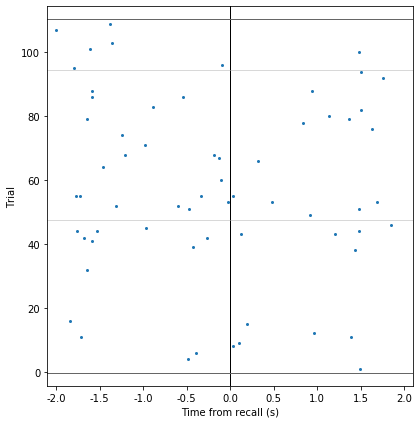

In [225]:
## for the raster and PSTH binarize the data by using the start indices of the ripple
%autoreload
psth_start = -2000
psth_end = 2000

# plot raster
subplots(1,1,figsize=(6,6))   
scatter(np.where(start_array)[1]*sr_factor+psth_start,np.where(start_array)[0],s=4) # SWR time v. trial
xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,0.5))
xlabel('Time from recall (s)')
ylabel('Trial')
tight_layout()
ax = plt.gca()
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]], linewidth=1,linestyle='-',color=(0,0,0))
last_sub = sub_names[0]
for s in range(1,len(trial_nums)):
    if sub_names[s] != last_sub:
        # plot dark gray line between subjects
        plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
        last_sub = sub_names[s]
    else: # plot light gray line between sessions
        plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=(.7,.7,.7))
plot([ax.get_xlim()[0],ax.get_xlim()[1]],-.5*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))        
plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums))*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
ax.autoscale(enable=True, axis='y', tight=True)
# print('Total FR events: '+str(total_recalls)) # these were in whole retrieval period so not kept in usual ripple alignment
# print('Kept FR events: '+str(kept_recalls))
print(start_array.shape);

In [203]:
# make a PSTH based on start times of SWRs
binsize = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = smoothing_triangle-3 # factor is how many points from middle does triangle go?

PSTH,bin_centers = fullPSTH(start_array,binsize,smoothing_triangle,sr,psth_start)
# bootstraps error bars by sampling from trials in raster with replacement samples number of
# times and then taking the standard deviation across those samples
boot_samples = bootstrap(start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
               bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,psth_start))
boot_SD = np.std(boot_samples,0)

# # create a resampling surrogate to probe chance and do cluster stats
# # the surrogate is samples number of PSTHs where the num of ripples kept constant
# # in each trial but the times were randomly shifted in those trials
# nbins = int(np.ceil(start_array.shape[1]/binsize))
# shuffledRate = np.zeros((nbins,samples))
# realRate = PSTH
# samples = 100
# num_trials = start_array.shape[0]
# time_length = start_array.shape[1]
# shuffledRate = []
# for i in range(samples):
#     # get list of trials with replacement and the number of ripples within them
#     rip_ct = np.sum(start_array,1)
#     permdata = np.zeros(np.shape(start_array))
#     for trial in range(num_trials):
#         if rip_ct[trial]>0:
#             rand_times = randint(0,time_length,int(rip_ct[trial])) # randomize rip times w/in each trial
#             permdata[trial,rand_times] = 1 # so each trial always has same # of SWRs
#     permPSTH,_ = fullPSTH(permdata,binsize,smoothing_triangle,sr,psth_start)        
#     shuffledRate = superVstack(shuffledRate,permPSTH) # sample X bins
# shuffledRate = shuffledRate[:,pad:-pad] # remove padded sides
# mean_shuffled_rate = np.mean(shuffledRate)
# shuffled_std = np.std(shuffledRate)

# # find significant clusters
# cluster_thresh = 1.96
# # get lower and upper 1.96 SD thresholds
# thresh = [mean_shuffled_rate-(cluster_thresh*shuffled_std),mean_shuffled_rate+(cluster_thresh*shuffled_std)]
# max_clusts = []
# for i in range(samples):
#     temp = (shuffledRate[i]<thresh[0]) | (shuffledRate[i]>thresh[1]) 
#     starts,ends = getLogicalChunks(temp)
#     if len(starts)>0:
#         temp_clust = (np.array(ends)-np.array(starts))+1 # length of each cluster
#         max_clusts.append(np.max(temp_clust)) # longest cluster
#     else: max_clusts.append(0)
# # actual data
# real_thresh_crosses = (realRate<thresh[0]) | (realRate>thresh[1])
# starts,ends = getLogicalChunks(real_thresh_crosses)
# real_clust = (np.array(ends)-np.array(starts))+1;
# bin_centers

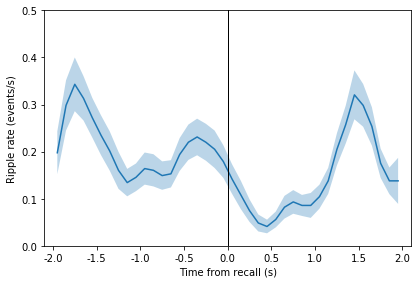

In [204]:
# is_sig_cluster = np.zeros(len(temp)) # get locations of significant clusters
# clusterPval = []
# sig_clust_ranges = []
# if sum(real_thresh_crosses)>0:
#     real_crossing_starts,_ = getLogicalChunks(real_thresh_crosses) # number of actual crosses is starts
#     for k in range(len(real_crossing_starts)): 
#         clusterPval.append( (np.sum(max_clusts>real_clust[k])+1) / (samples+1))
#         if clusterPval[k]<0.05:
#             is_sig_cluster[starts[k]:ends[k]+1]=1
#     max_cluster_actual_data = np.max(real_clust)
#     # convert significant clsuters to bins
#     clust_start,clust_end = getLogicalChunks(is_sig_cluster)
#     for cl in range(len(clust_start)):
#         sig_bins = bin_centers[clust_start[cl]:clust_end[cl]+1] # get sig. bins and create xvalues for a line
#         sig_clust_ranges.append([np.min(sig_bins)-binsize/2,np.max(sig_bins)+binsize/2])

# plot PSTH
subplots(1,1,figsize=(6,4))
xr = bin_centers #np.arange(psth_start,psth_end,binsize)
#plot(xr,norm_count[0]) # actual data
plot(xr,PSTH)
fill_between(xr, PSTH+boot_SD, PSTH-boot_SD, alpha = 0.3)
# bootstrap SE using random sample with replacement

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
xlabel('Time from recall (s)')
ylabel('Ripple rate (events/s)')
tight_layout()
ax = plt.gca()
ylim = 0.5
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
x_width = [ax.get_xlim()[0],ax.get_xlim()[1]]
# plot(x_width,list(mean_shuffled_rate*np.ones(2)),linewidth=1,color=(0.5,0.5,0.5));
# plot(x_width,list((mean_shuffled_rate+shuffled_std)*np.ones(2)),linewidth=1,linestyle='--',color=(0.5,0.5,0.5));
# plot(x_width,list((mean_shuffled_rate-shuffled_std)*np.ones(2)),linewidth=1,linestyle='--',color=(0.5,0.5,0.5));
# if len(sig_clust_ranges)>0:
#     for cl in range(len(sig_clust_ranges)):
#         plot(sig_clust_ranges[cl],[ylim*0.9,ylim*0.9],color=(1,0.7,0.23),linewidth=3)
#         print('Cluster p-value: '+str(clusterPval[cl]))
# else: print('Largest cluster p-value is: '+str(clusterPval[0]))
a=1;

## Plots by hippocampal subfield!

In [37]:
# Let's plot the change in SWRs by subfield
pre_time = -1000 # how long to look for ripples before/after recall
post_time = 1000
# CA1/CA3/DG/sub are 4 regions
ca1 = []; ca3 = []; subic = []; dg = []
ca1_tn = []; ca3_tn = []; subic_tn = []; dg_tn = []
previous_row = 0
for s in range(len(HPC_names)):
    # first, get the change in SWRs from before until after recall
    new_trials = trial_nums[s]
    if HPC_names[s].find('ca1')>=0:
        ca1 = superVstack(ca1,start_array[previous_row:int(previous_row+new_trials)])
        ca1_tn = np.append(ca1_tn,new_trials) # record trial numbers for raster plot
    elif HPC_names[s].find('ca3')>=0:
        ca3 = superVstack(ca3,start_array[previous_row:int(previous_row+new_trials)])
        ca3_tn = np.append(ca3_tn,new_trials)
    elif HPC_names[s].find('sub')>=0:
        subic = superVstack(subic,start_array[previous_row:int(previous_row+new_trials)])
        subic_tn = np.append(subic_tn,new_trials)
    elif HPC_names[s].find('dg')>=0:
        dg = superVstack(dg,start_array[previous_row:int(previous_row+new_trials)])
        dg_tn = np.append(dg_tn,new_trials)
    previous_row = int(previous_row+new_trials)
separate_HPC_arrays = np.array([ca1,ca3,subic,dg])
separate_HPC_tns = np.array([ca1_tn,ca3_tn,subic_tn,dg_tn])

[960.0, 226.0, 227.0, 415.0]


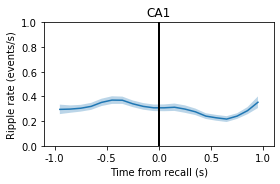

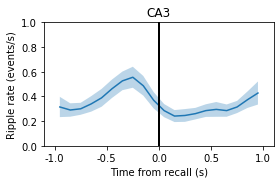

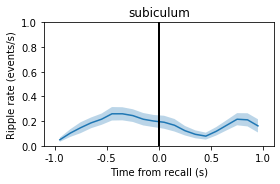

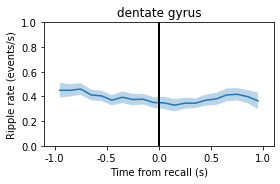

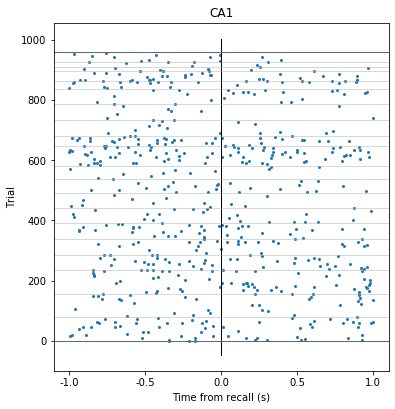

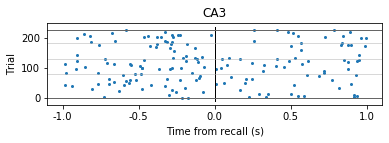

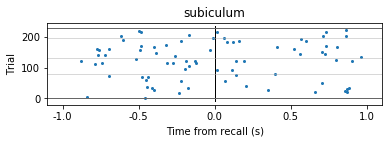

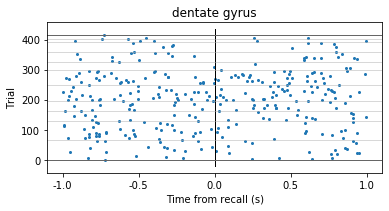

In [38]:
# plot the separate PSTHs
# make a PSTH based on start times of SWRs
binsize = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = smoothing_triangle-3 # factor is how many points from middle does triangle go?
xripplerange = range(int(abs(pre_time)/sr_factor),
                     int((abs(pre_time)+(post_time-pre_time))/sr_factor))
plot_names = ['CA1','CA3','subiculum','dentate gyrus']

for pl in range(4):
    temp_start_array = separate_HPC_arrays[pl][:,xripplerange]

    PSTH,bin_centers = fullPSTH(temp_start_array,binsize,smoothing_triangle,sr,pre_time)
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
    boot_samples = bootstrap(temp_start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
                   bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,pre_time))
    boot_SD = np.std(boot_samples,0)

    # plot PSTH
    subplots(1,1,figsize=(4,8/3))
    xr = bin_centers #np.arange(pre_time,post_time,binsize)
    plot(xr,PSTH)
    fill_between(xr, PSTH+boot_SD, PSTH-boot_SD, alpha = 0.3)

    xticks(np.arange(pre_time,post_time+1,500),np.arange(pre_time/1000,post_time/1000+1,500/1000))
    xlabel('Time from recall (s)')
    ylabel('Ripple rate (events/s)')
    ax = plt.gca()
    ax.set_ylim(0,1.0)
    ax.set_xlim(pre_time-100,post_time+100)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=2,linestyle='-',color=(0,0,0))
    title(plot_names[pl])
    tight_layout()


for pl in range(4):
    temp_start_array = separate_HPC_arrays[pl][:,xripplerange]
    temp_trial_num_array = separate_HPC_tns[pl]

    # plot rasters for each
    subplots(1,1,figsize=(6,sum(temp_trial_num_array)/150))   
    scatter(np.where(temp_start_array)[1]*sr_factor+pre_time,np.where(temp_start_array)[0],s=4) # SWR time v. trial
    xticks(np.arange(pre_time,post_time+1,500),np.arange(pre_time/1000,post_time/1000+1,0.5))
    xlabel('Time from recall (s)')
    ylabel('Trial')
    ax = plt.gca()
    ax.set_xlim(pre_time-100,post_time+100)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]], linewidth=1,linestyle='-',color=(0,0,0))
    tn_ct = 0
    for tn in temp_trial_num_array:
        tn_ct = tn_ct + tn
        plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+tn_ct)*np.ones(2),linewidth=0.5,linestyle='-',color=(.7,.7,.7))
    plot([ax.get_xlim()[0],ax.get_xlim()[1]],-.5*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))        
    plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+tn_ct)*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
    title(plot_names[pl])
print([sum(xx) for xx in separate_HPC_tns]);

## What about SWR ripple_durations?! Expect longer = better memory

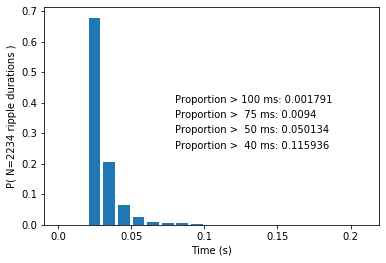

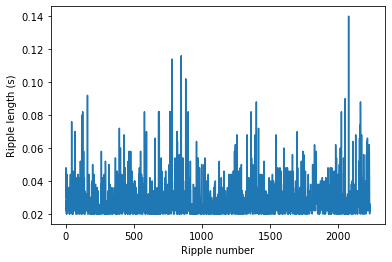

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/home1/john/johnModules/general.py:76: RuntimeWarning: invalid value encountered in true_divide
  stderr = np.sqrt(num_correct*(1-num_correct/trials)/(trials-1)) / np.sqrt(trials)


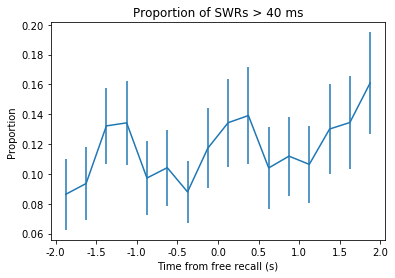

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:68: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


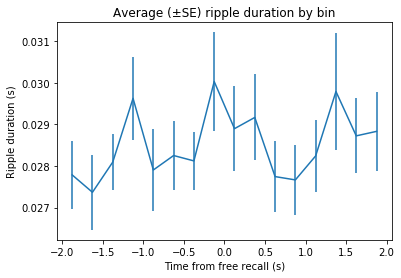

In [39]:
%autoreload
# get ripple_durations
ripple_durations = []
ripple_midpoints = []
for trial in range(start_array.shape[0]):
    starts = np.array(np.where(start_array[trial]))
    ends = np.array(np.where(end_array[trial]))
    ripple_durations = np.append(ripple_durations,ends-starts)
    ripple_midpoints = np.append(ripple_midpoints,starts+(ends-starts)/2)
ripple_durations = ripple_durations*sr_factor/1000 # convert to s
sum(start_array)

plotHistoBar(ripple_durations,0,0.2,0.01,tick_range_divisor=5,normalize=True)
xlabel('Time (s)')
ylabel('P( N='+str(len(ripple_durations))+' ripple durations )')
text(0.08,0.4,'Proportion > 100 ms: '+str(np.round(sum(ripple_durations>=0.1)/len(ripple_durations),6)))
text(0.08,0.35,'Proportion >  75 ms: '+str(np.round(sum(ripple_durations>=0.075)/len(ripple_durations),6)))
text(0.08,0.3,'Proportion >  50 ms: '+str(np.round(sum(ripple_durations>=0.05)/len(ripple_durations),6)))
text(0.08,0.25,'Proportion >  40 ms: '+str(np.round(sum(ripple_durations>=0.04)/len(ripple_durations),6)))
plt.show()
plot(ripple_durations)
xlabel('Ripple number')
ylabel('Ripple length (s)')
plt.show()

# what about ripple_durations of ripples in the PSTH? Are they longer just before recall?
# could be clever and like use time of peak power but makes just as much sense to use midpoint
# get midpoint list from for loop above
ripple_midpoints = (ripple_midpoints*sr_factor+-2000)/1000 # convert to s and adjust to offset

# now, look at proportion of ripples > 40 ms in each bin
ripples_over_40_ms = ripple_midpoints[ripple_durations>=0.04]
bin_size = 0.25
bins = np.arange(-2,2+bin_size+bin_size+0.001,bin_size)
histogram_over_40 = np.histogram(ripples_over_40_ms,bins)
histogram_of_all = np.histogram(ripple_midpoints,bins)
proportion_over_40= histogram_over_40[0]/histogram_of_all[0]
# proportion_over_40[np.isnan(proportion_over_40)] = 0

yvalues = proportion_over_40
tick_range_divisor = 2

xr = (bins[1:]+bins[:-1])/2
ax = errorbar(xr,yvalues,yerr=seFromProp(histogram_over_40[0],histogram_of_all[0]))

# get ticks
wanted_ticks = np.arange(bins[0],bins[-1]+bin_size/1000,bin_size*tick_range_divisor)
wanted_ticks = np.around(wanted_ticks,3) # for some reason arange loses precision sometimes
ticks = []
has_ticks = []
for tick in bins:
    if tick in wanted_ticks:
        ticks.append(tick)
        has_ticks.append(True)
    else:
        has_ticks.append(False)
xticks(xr[has_ticks[:-1]]-bin_size/2,ticks) # [:-1 since took midpoints to get xr above]
ylabel('Proportion')
xlabel('Time from free recall (s)')
title('Proportion of SWRs > 40 ms'); plt.show()

# Could also plot durations at each time bin
mean_durations_by_bin = []
se_durations_by_bin = []
for bin in bins[:-3]:
    # get indices for times in each bin so can grab durations
    ripples_in_bin = [(ripple_midpoints>=bin) & (ripple_midpoints<bin+bin_size)]
    durations_in_bin = ripple_durations[ripples_in_bin]
    mean_durations_by_bin.append(np.mean(durations_in_bin))
    se_durations_by_bin.append(np.std(durations_in_bin)/np.sqrt(len(durations_in_bin)))
errorbar(xr[:-2],mean_durations_by_bin,yerr=se_durations_by_bin)
ylabel('Ripple duration (s)')
xlabel('Time from free recall (s)')
title('Average (±SE) ripple duration by bin');

In [307]:
fr_array.shape
start_array.shape
start_array2.shape
sum(fr_array)

(917, 30000)

(1878, 2000)

(917, 17000)

1878.0

## SWRs by time in retrieval period

In [308]:
# going to have to grab chunks of ripplearray for each FR for early/mid/late 10 s of retrieval
# make sure to add 2000 since start_array2 is 30 s with 2 s buffers on either side in order to grab 2 s before/after FR

retrieval_periods = ['early','middle','late']
early_array = []; middle_array = []; late_array = []
retrieval_whole_time = 30000 #90000 if you want to see whole 30 s period
third_of_retrieval_ms = retrieval_whole_time/3
test = []
for trial in range(start_array2.shape[0]):
    for i,retrieval_period in enumerate(retrieval_periods):
        # for each trial get the FRs in each of the 3 slices of the retrieval period
        time_slice_tercile = range(int(third_of_retrieval_ms*(i)),int(third_of_retrieval_ms*(i+1)))
        time_slice_recalls = np.where(fr_array[trial,time_slice_tercile])[0]
        for time_slice_recall in time_slice_recalls:
            # this time is in ms from start of each retrieval slice...convert to samples since start_array2 in samples
            raster_surrounding_recall = range( int(np.ceil((psth_start+time_slice_recall-psth_start)/sr_factor)),
                                               int(np.ceil((psth_end+time_slice_recall-psth_start)/sr_factor)) )
            test.append(min(raster_surrounding_recall))
            if retrieval_period=='early':
                early_array = superVstack(early_array,start_array2[trial,raster_surrounding_recall])
            elif retrieval_period=='middle':
                middle_array = superVstack(middle_array,start_array2[trial,raster_surrounding_recall])
            elif retrieval_period=='late':
                late_array = superVstack(late_array,start_array2[trial,raster_surrounding_recall])
print('Done retrieving arrays')

Done retrieving arrays


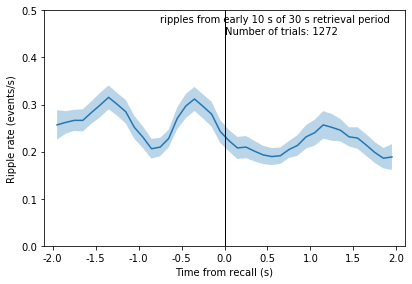

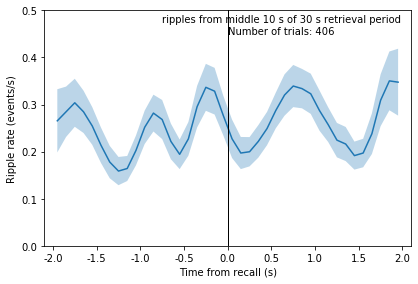

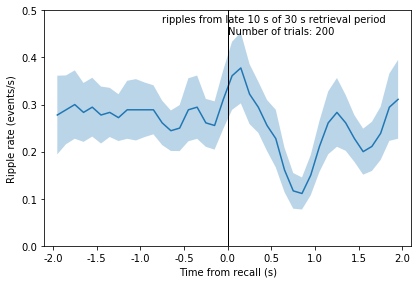

In [309]:
# what about where in retrieval period? I think best way to look at this
# will be to divide retrieval period into early, middle, and late and 
# make SWR PSTHs for each of these periods

for retrieval_period in retrieval_periods:
    if retrieval_period=='early':
        temp_start_array = early_array
    elif retrieval_period=='middle':
        temp_start_array = middle_array
    elif retrieval_period=='late':
        temp_start_array = late_array
    # make a PSTH based on start times of SWRs
    binsize = 100 # in ms
    smoothing_triangle = 5 # triangular smoothing window width
    samples = 100
    pad = smoothing_triangle-3 # factor is how many points from middle does triangle go?

    PSTH,bin_centers = fullPSTH(temp_start_array,binsize,smoothing_triangle,sr,psth_start)
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
    boot_samples = bootstrap(temp_start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
                   bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,psth_start))
    boot_SD = np.std(boot_samples,0)

    subplots(1,1,figsize=(6,4))
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    #plot(xr,norm_count[0]) # actual data
    plot(xr,PSTH)
    fill_between(xr, PSTH+boot_SD, PSTH-boot_SD, alpha = 0.3)
    xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
    xlabel('Time from recall (s)')
    ylabel('Ripple rate (events/s)')
    tight_layout()
    ax = plt.gca()
    ylim = 0.5
    ax.set_ylim(0,ylim)
    ax.set_xlim(psth_start-100,psth_end+100)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
    text(-750,0.475,'ripples from '+retrieval_period+' 10 s of 30 s retrieval period')
    text(0,0.45,'Number of trials: '+str(temp_start_array.shape[0]))
    plt.show()
a=1;

## Do we see more SWRs during successful encoding?

In [20]:
desired_sample_rate = 500.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate
start_array_enc,end_array_enc = getStartEndArrays(ripple_array_enc,sr)
master_key = []
for enc_words in encoded_word_key_array:
    master_key.extend(enc_words)
master_key = np.array(master_key)
start_array_enc_forgot = start_array_enc[master_key==0]
start_array_enc_recalled = start_array_enc[master_key==1]

NameError: name 'ripple_array_enc' is not defined

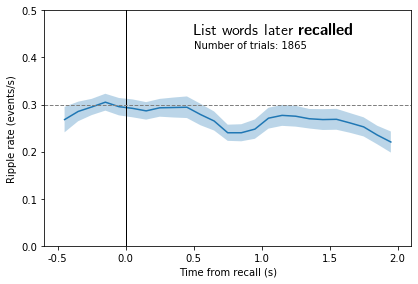

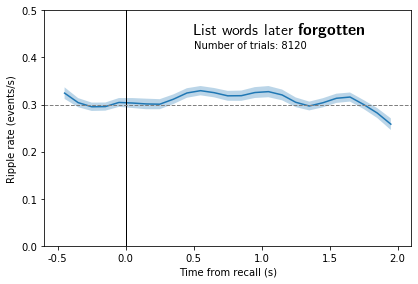

In [299]:
for mem in range(2):
    if mem == 0:
        label = 'List words later \\textbf{recalled} '
        temp_start_array = start_array_enc_recalled
    elif mem==1:
        label = 'List words later \\textbf{forgotten}'
        temp_start_array = start_array_enc_forgot
    # make a PSTH based on start times of SWRs
    binsize = 100 # in ms
    smoothing_triangle = 5 # triangular smoothing window width
    samples = 100
    pad = smoothing_triangle-3 # factor is how many points from middle does triangle go?

    PSTH,bin_centers = fullPSTH(temp_start_array,binsize,smoothing_triangle,sr,pre_encoding_time)
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
    boot_samples = bootstrap(temp_start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
                   bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,psth_start))
    boot_SD = np.std(boot_samples,0)

    subplots(1,1,figsize=(6,4))
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    #plot(xr,norm_count[0]) # actual data
    plot(xr,PSTH)
    fill_between(xr, PSTH+boot_SD, PSTH-boot_SD, alpha = 0.3)
    xticks(np.arange(pre_encoding_time,encoding_time+1,500),np.arange(pre_encoding_time/1000,encoding_time/1000+1,500/1000))
    xlabel('Time from recall (s)')
    ylabel('Ripple rate (events/s)')
    tight_layout()
    ax = plt.gca()
    ylim = 0.5
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time-100,encoding_time+100)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
    plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0.3,0.3],linewidth=1,linestyle='--',color=(0.5,0.5,0.5));
    text(500,0.45,label,usetex=True,size=16)
    text(500,0.42,'Number of trials: '+str(temp_start_array.shape[0]))
    plt.show()
a=1;

In [21]:
sum(master_key==2)
sum(master_key==1)
sum(master_key==0)

NameError: name 'master_key' is not defined

## let's look at some of these SWR traces! 

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1010J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1010J/tal/R1010J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1010J/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1010J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-

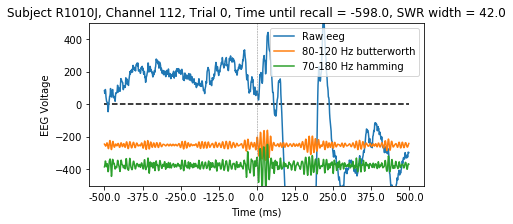

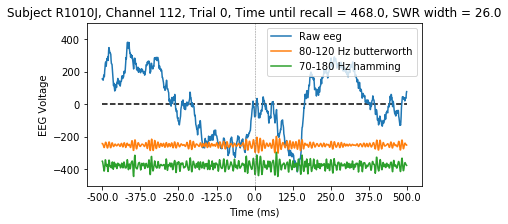

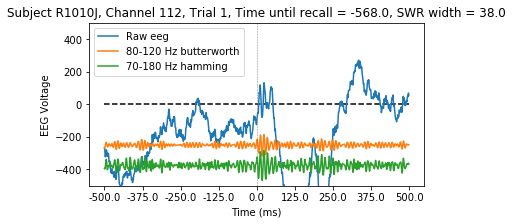

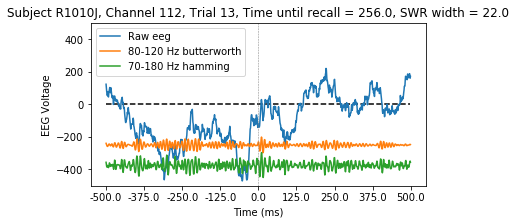

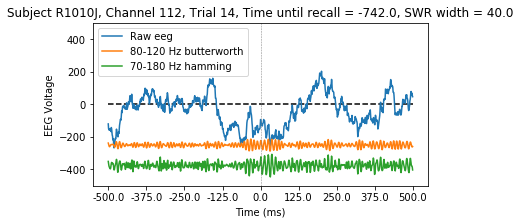

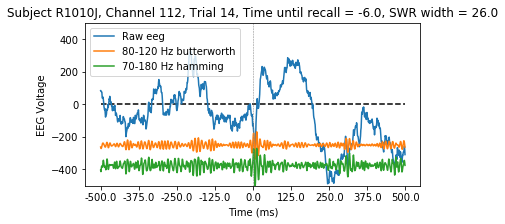

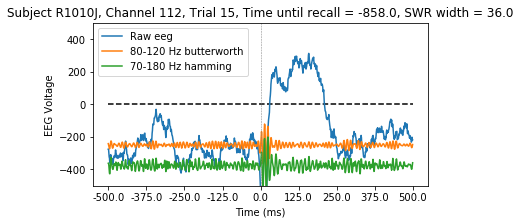

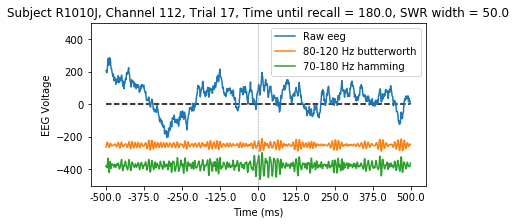

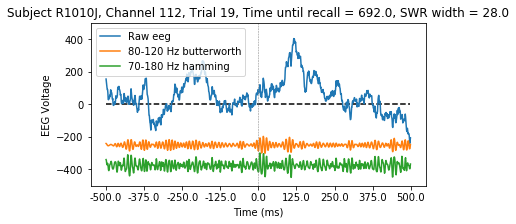

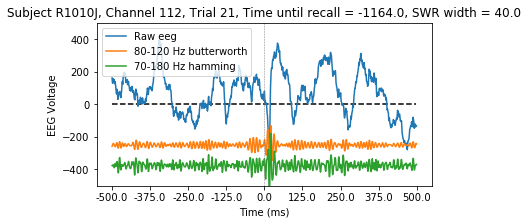

In [569]:
# Need to run top eeg load first to get start_array and sr.
# start_array is recall_events X time with binary 1 for start of each detected SWR

%autoreload
from ptsa.data.filters import ButterworthFilter
from scipy.signal import firwin,filtfilt

which_session = 0 # select from the df
first_trial = 0
trials_to_print = 10 # note: will skip trials with no ripples

desired_sample_rate = 500.
desired_sr_factor = 1000/desired_sample_rate # even if SR is >500 for eeg the desired rate for the ripple arrays is set to 500
trans_width = 5.

# bb,aa = butter(2,[70/250,180/250],btype='band') # Butterworth test filter

temp_sub_df = sub_df[0:which_session+1] 
array_trial_offset = int(np.sum(trial_nums[:which_session]))
temp_sub_df

pre_rip = -500 # plots this many ms before and after the ripple
post_rip = 500

ymin = -500 #np.min(stim_eeg[trial,:])
ymax = 500 #np.max(stim_eeg[trial,:])
display_mult = 2 # increase 80-120 Hz by this factor to see it better on graph
y_offset = -ymax/2 # move 80-120 filtered band down for visualization purposes

yr = np.arange(ymin,ymax)
num_ripples = np.sum(start_array)

trial_ct = 0; print_ct = 0
for row in temp_sub_df.itertuples():
    # get bipolar pairs
    sub = row.subject; mont = int(row.montage); loc = int(row.localization)
    exp = row.experiment; session = int(row.session)
    reader = CMLReadDFRow(row)
    evs = reader.load('task_events')
    pairs = reader.load('pairs')
    evs_free_recall = evs[evs.type=='REC_WORD']
    # remove events with Inter-Recall Intervals too small. Use start time since that's what will show in PSTH
    evs_free_recall = evs_free_recall[np.append(True,np.diff(evs_free_recall.mstime)>IRI)] #abs(start))]
    tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
    elec_regions,_ = get_elec_regions(tal_struct)      
    
    eeg = reader.load_eeg(events=evs_free_recall, rel_start=psth_start, rel_stop=psth_end, clean=True, scheme=pairs)
    eeg_sr = eeg.samplerate
    
    ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(eeg_sr/trans_width)
    FIR_filter = firwin(int(ntaps+1), [70.,180.], fs=eeg_sr, window='hamming',pass_zero='bandpass')
    
    sr_factor = 1000/eeg_sr
    xr = np.arange(0,(post_rip-pre_rip)/sr_factor)
    eeg_ptsa = eeg.to_ptsa()
    eeg_ptsa = eeg_ptsa.baseline_corrected((psth_start,psth_end))
    eeg_vaz = eeg_ptsa.filtered([80.,120.], filt_type='bandpass', order=2) # Butterworth 2nd order a la Vaz/Zaghloul
    eeg_norman = filtfilt(FIR_filter,1.,eeg_ptsa) 
#     eeg_butter_70180 = filtfilt(bb,aa,eeg_ptsa) # test Butterworth with 70-180 Hz...like combining two methods
#     eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
    
    for channel in range(len(elec_regions)):
        if elec_regions[channel] in HPC_labels:
            for trial in range(len(evs_free_recall)): # maximum trials is # elecs * recall_events
                if trial_ct >= (first_trial) and print_ct<trials_to_print:
                    if np.sum(start_array[trial_ct+array_trial_offset])>0: # if there is a ripple in this trial
                        rip_times = (np.array(np.where(start_array[trial_ct]))*desired_sr_factor)[0] # convert to ms
                        rip_durations = ((desired_sr_factor*np.array(np.where(end_array[trial_ct])))-rip_times)[0]
                        for rip in range(len(rip_times)): # get each ripple 
                            rip_time = rip_times[rip]
                            rip_length = rip_durations[rip]
                            #print(str(rip_time+psth_start))
                            # note: any time dealing with eeg, need to account for sampling rate (see all the sr_factors)
                            if rip_time>abs(pre_rip) and rip_time<(eeg_ptsa.shape[2]*sr_factor-abs(post_rip)): # if enough time before/after ripple to plot
                                stim_eeg = eeg_ptsa[trial_ct,channel,int((rip_time+pre_rip)/sr_factor):int((rip_time+post_rip)/sr_factor)]
                                filt_eeg_vaz = eeg_vaz[trial_ct,channel,int((rip_time+pre_rip)/sr_factor): # eeg_butter_70180
                                                                int((rip_time+post_rip)/sr_factor)]
                                filt_eeg_norman = eeg_norman[trial_ct,channel,int((rip_time+pre_rip)/sr_factor):
                                                             int((rip_time+post_rip)/sr_factor)]
                                plt.figure(figsize=(6, 3)) 
                                ax = plt.subplot(111)
                                plt.plot(xr,stim_eeg)
                                plt.plot(xr,display_mult*filt_eeg_vaz+y_offset)
                                plt.plot(xr,display_mult*filt_eeg_norman+y_offset*3/2)
                                plt.ylabel('EEG Voltage'); plt.xlabel('Time (ms)')
                                plt.plot(abs(pre_rip/sr_factor)*np.ones(len(yr)),yr,marker='',linewidth=0.5,linestyle='--',color=[0.5,0.5,0.5])
                                plt.legend(['Raw eeg','80-120 Hz butterworth','70-180 Hz hamming']) 
                                plt.title('Subject '+sub+', Channel '+str(channel)+', Trial '+str(trial_ct)+', Time until recall = '
                                          +str(rip_time+psth_start)+', SWR width = '+str(rip_length))
                                plt.xticks(np.arange(0,post_rip-pre_rip+1,post_rip/4),np.arange(pre_rip,post_rip+1,post_rip/4))
                                ax.set_ylim([ymin,ymax])
                                plt.hlines(0,xr[0],xr[-1], linestyle='--', color='k')
                                print_ct+=1
                trial_ct+=1 # keep track of which trial we're on out of total ELEC X RECALL trials
a=1;

## What about visualizing IED events?

array([ 0.,  0., 14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.])

(32, 2000)

500.0

(32, 2000)

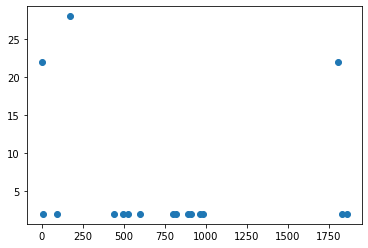

In [49]:
scatter(np.where(start_array)[1],np.where(start_array)[0])
np.sum(start_array,1)
start_array.shape
sr
iedlogic.shape

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1112M/tal/R1112M_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1112M/eeg.noreref/R1112M_FR1_0_01Dec15_1545.params.txt
/data/eeg/R1112M/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePath

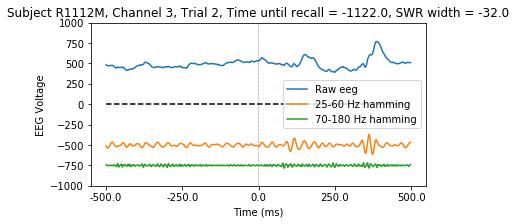

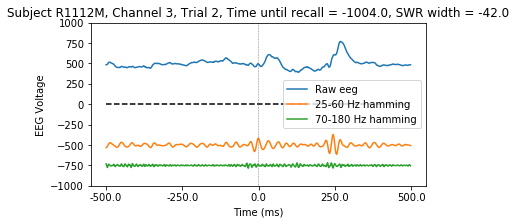

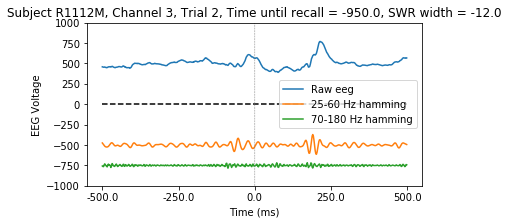

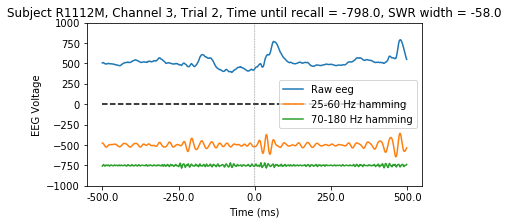

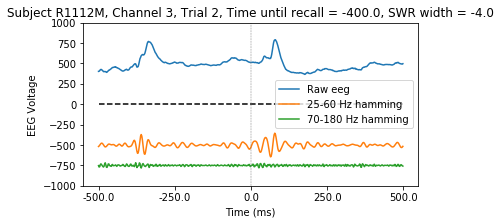

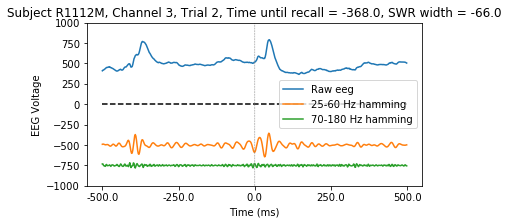

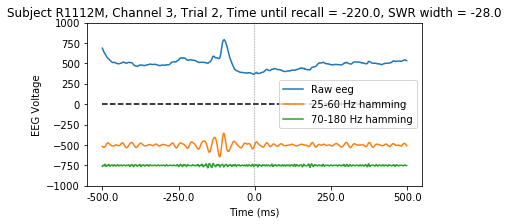

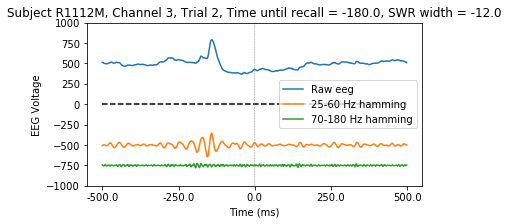

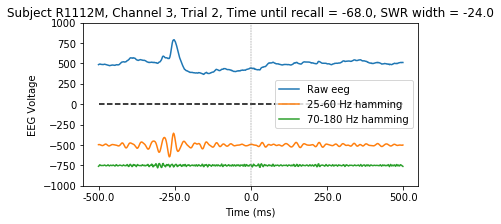

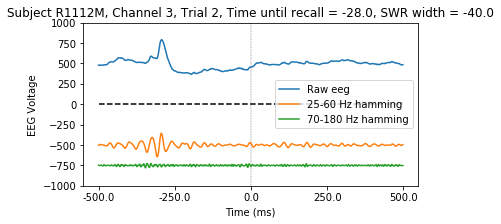

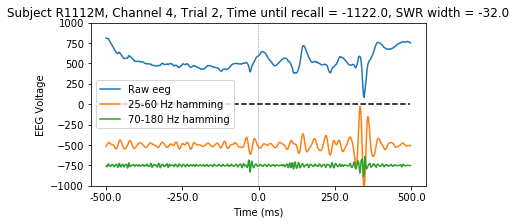

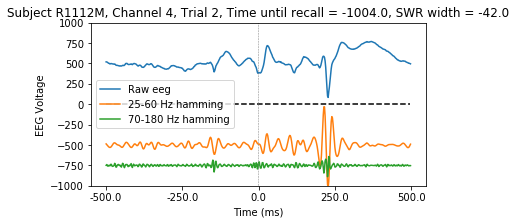

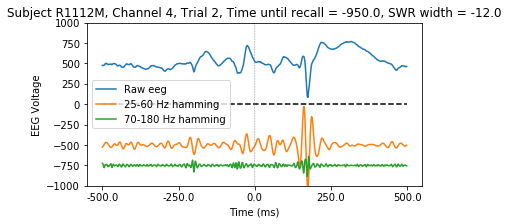

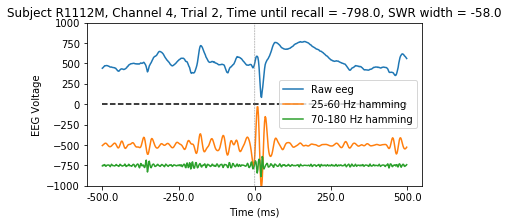

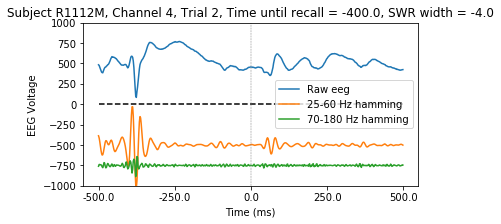

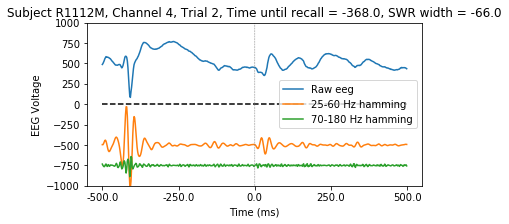

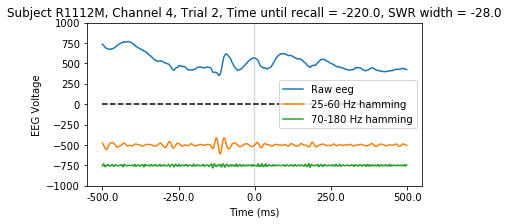

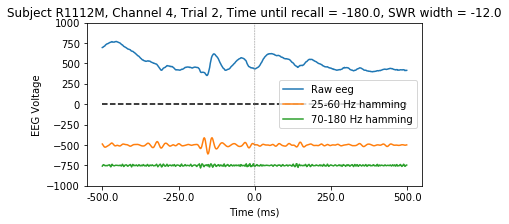

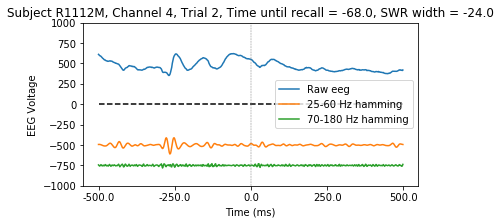

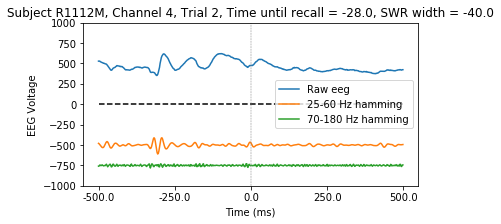

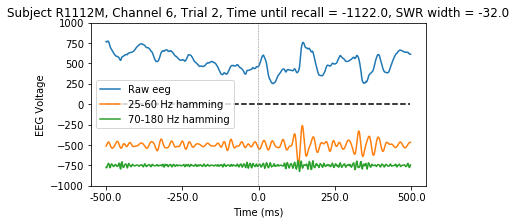

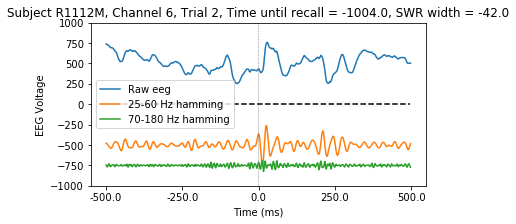

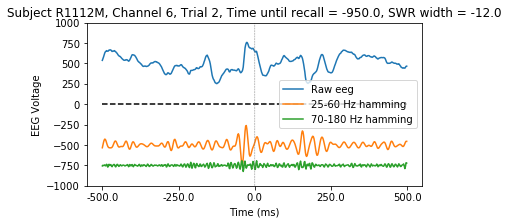

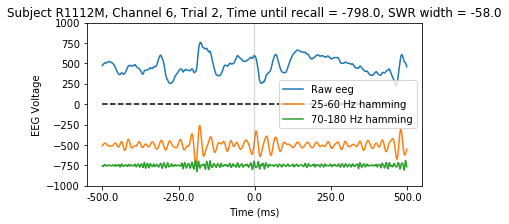

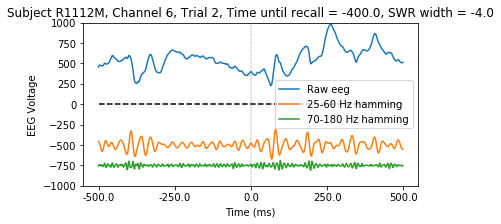

In [66]:
# create a start_array for IED array

desired_sample_rate = 500.
# iedlogic = downsampleBinary(iedlogic,sr/desired_sample_rate)
start_array,end_array = getStartEndArrays(iedlogic,sr)

sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
desired_sr_factor = 1000/desired_sample_rate

%autoreload
from ptsa.data.filters import ButterworthFilter
from scipy.signal import firwin,filtfilt

which_session = 0 # select from the df
first_trial = 0
trials_to_print = 25 # note: will skip trials with no ripples

display_mult_ied = 3 # display IED multiplier
display_mult_rip = 5

pre_rip = -500 # plots this many ms before and after the ripple
post_rip = 500
trans_width = 5.
temp_sub_df = sub_df[0:which_session+1] 
array_trial_offset = int(np.sum(trial_nums[:which_session]))
temp_sub_df

ymin = -1000 #np.min(stim_eeg[trial,:])
ymax = 1000 #np.max(stim_eeg[trial,:])
y_offset = -ymax/2 # move 80-120 filtered band down for visualization purposes

yr = np.arange(ymin,ymax)
num_ripples = np.sum(start_array)

trial_ct = 0; print_ct = 0
for row in temp_sub_df.itertuples():
    # get bipolar pairs
    sub = row.subject; mont = int(row.montage); loc = int(row.localization)
    exp = row.experiment; session = int(row.session)
    reader = CMLReadDFRow(row)
    evs = reader.load('task_events')
    pairs = reader.load('pairs')
    evs_free_recall = evs[evs.type=='REC_WORD']
    # remove events with Inter-Recall Intervals too small. Use start time since that's what will show in PSTH
    evs_free_recall = evs_free_recall[np.append(True,np.diff(evs_free_recall.mstime)>IRI)] #abs(start))]
    tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
    elec_regions,_ = get_elec_regions(tal_struct)      
    
    eeg = reader.load_eeg(events=evs_free_recall, rel_start=psth_start, rel_stop=psth_end, clean=True, scheme=pairs)
    eeg_sr = eeg.samplerate
    
    ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(eeg_sr/trans_width)
    FIR_filter = firwin(int(ntaps+1), [70.,180.], fs=eeg_sr, window='hamming',pass_zero='bandpass')
    bandpass_25_60 = firwin(int(ntaps+1), [25.,60.], fs=eeg_sr, window='hamming',pass_zero='bandpass')
    
#     sr_factor = 1000/eeg_sr
    xr = np.arange(0,(post_rip-pre_rip)/desired_sr_factor)
    eeg_ptsa = eeg.to_ptsa()
    eeg_ptsa = eeg_ptsa.baseline_corrected((psth_start,psth_end))
#     eeg_vaz = eeg_ptsa.filtered([80.,120.], filt_type='bandpass', order=2) # Butterworth 2nd order a la Vaz/Zaghloul
    ied_norman = filtfilt(bandpass_25_60,1.,eeg_ptsa)
#     ied_vaz = ButterworthFilter(timeseries=eeg_ptsa, freq_range=200., filt_type='highpass',order=2).filter()
    eeg_norman = filtfilt(FIR_filter,1.,eeg_ptsa) 
#     eeg_butter_70180 = filtfilt(bb,aa,eeg_ptsa) # test Butterworth with 70-180 Hz...like combining two methods
#     eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
    
    for channel in range(len(elec_regions)):
        if elec_regions[channel] in HPC_labels:
            for trial in range(np.shape(start_array)[0]): # maximum trials is # elecs * recall_events
                rip_times = np.where(start_array[trial])[0]*desired_sr_factor # times in ms
                rip_ends = np.where(end_array[trial])[0]*desired_sr_factor
                if sum(rip_times)>0:
                    for i,rip_time in enumerate(rip_times):
                        if print_ct<trials_to_print:
    #                     if np.sum(start_array[trial_ct+array_trial_offset])>0: # if there is a ripple in this trial
                            rip_length = rip_time-rip_ends[i]
    #                         for rip in range(len(rip_times)): # get each ripple 
                            #print(str(rip_time+psth_start))
                            # note: any time dealing with eeg, need to account for sampling rate (see all the sr_factors)
                            if rip_time>abs(pre_rip) and rip_time<(eeg_ptsa.shape[2]*desired_sr_factor-abs(post_rip)): # if enough time before/after ripple to plot
                                stim_eeg = eeg_ptsa[trial,channel,int((rip_time+pre_rip)/desired_sr_factor):int((rip_time+post_rip)/sr_factor)]
                                filt_ied_norman = ied_norman[trial,channel,int((rip_time+pre_rip)/desired_sr_factor): # eeg_butter_70180
                                                                int((rip_time+post_rip)/desired_sr_factor)]
                                filt_eeg_norman = eeg_norman[trial,channel,int((rip_time+pre_rip)/desired_sr_factor):
                                                             int((rip_time+post_rip)/desired_sr_factor)]
                                plt.figure(figsize=(6, 3)) 
                                ax = plt.subplot(111)
                                plt.plot(xr,stim_eeg-y_offset)
                                plt.plot(xr,display_mult_ied*filt_ied_norman+y_offset)
                                plt.plot(xr,display_mult_rip*filt_eeg_norman+y_offset*3/2)
                                plt.ylabel('EEG Voltage'); plt.xlabel('Time (ms)')
                                plt.plot(abs(pre_rip/desired_sr_factor)*np.ones(len(yr)),yr,marker='',linewidth=0.5,linestyle='--',color=[0.5,0.5,0.5])
                                plt.legend(['Raw eeg','25-60 Hz hamming','70-180 Hz hamming']) 
#                                 plt.legend(['Raw eeg','>200 Hz highpass','70-180 Hz hamming']) 
                                plt.title('Subject '+sub+', Channel '+str(channel)+', Trial '+str(trial)+', Time until recall = '
                                          +str(rip_time+psth_start)+', SWR width = '+str(rip_length))
                                plt.xticks(np.arange(0,post_rip-pre_rip+1,post_rip/4),np.arange(pre_rip,post_rip+1,post_rip/2))
                                ax.set_ylim([ymin,ymax])
                                plt.hlines(0,xr[0],xr[-1], linestyle='--', color='k')
                                print_ct+=1
#                 trial_ct+=1 # keep track of which trial we're on out of total ELEC X RECALL trials
a=1;

In [89]:
## NEVERMIND. Do it based on ISI of recall times, NOT ripple times. That's actually what Norman et al did.
# # Now that we have a start_array with all ripples, need to check ISIs to make sure
# # we're not double-dipping on recall events. For example, if two recall events
# # are only 500 ms apart, we don't want to put the same ripple in the PSTH twice just 500 ms apart
# # remove duplicate ripples < this interripple interval (IRI) time.
# IRI_thresh = abs(start) # Setting to start (PSTH beginning time) makes sense for PSTH
# ripple_idxs = np.where(ripple_mstime_array)
# ripple_abs_times = ripple_mstime_array[ripple_idxs]
# IRIs = np.diff(ripple_abs_times) # inter-ripple intervals
# 
# # this looks at current IRI and cumulative IRIs and eliminates everything but first one
# for rip in range(len(IRIs)): # for each ripple, check if next ripples are within IRI_thresh
#     if IRIs[rip]<=IRI_thresh:
#         # find how many into future are <=IRI_thresh
#         next_rip = 1
#         while np.sum(IRIs[rip:rip+next_rip])<=IRI_thresh:            
#             next_rip+=1
#             if (rip+next_rip)>=len(IRIs):
#                 break
#         # now you know how many ripples to remove
#         IRIs[rip:rip+next_rip-1] = Inf # so it won't be caught again in next step of for loop
#          # +1 below because used diff so always removing ripples after 1st
#         start_array[ripple_idxs[0][rip+1:rip+1+next_rip],ripple_idxs[1][rip+1:rip+1+next_rip]] = 0
#         # note: end_array can be left alone, since it's only indexed after finding a ripple from start_array

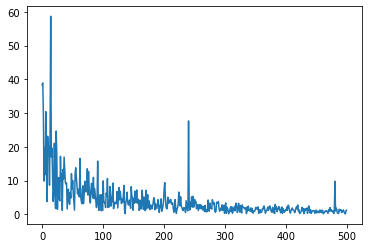

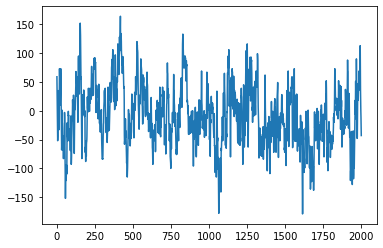

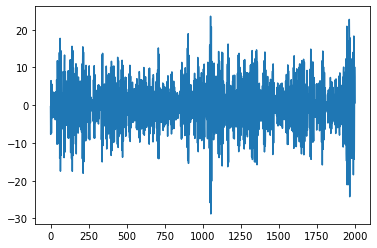

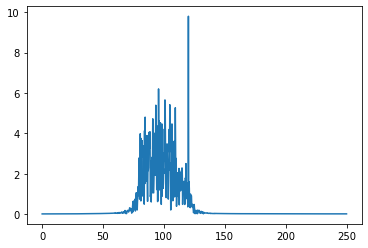

In [482]:
# example fft plot from https://intellipaat.com/community/32125/plotting-a-fast-fourier-transform-in-python
from scipy import fft 

N = 1000 # Number of samplepoints 
T = 1.0 / N # sample spacing 
x = np.linspace(0.0, N*T, N) 

# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
y = temp
filt80120 = temp.filtered([80,120],order=4,filt_type='bandpass')

yf = fft(y) 
xf = np.linspace(0.0, N/2, N/2) 
fig,ax = plt.subplots() 
ax.plot(xf, 2.0/N * np.abs(yf[:N//2])) 
plt.show()

plt.plot(y)
plt.show()
plt.plot(z)
plt.show()

fft_filt80120 = fft(filt80120)
NN = len(filt80120)
xff = np.linspace(0,NN/8,NN/2) # I think this is 4000 ms/500 SR to get 8
plt.plot(xff,8/NN*np.abs(fft_filt80120[:NN//2]))

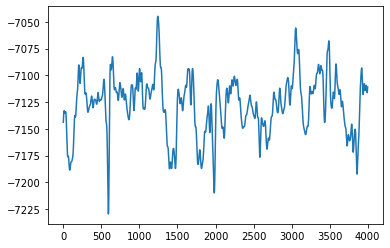

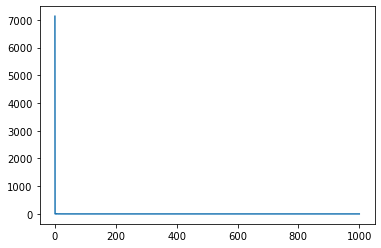

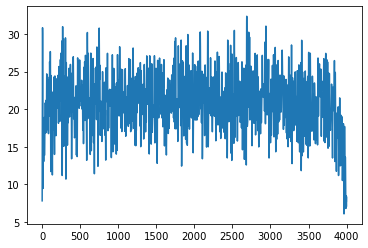

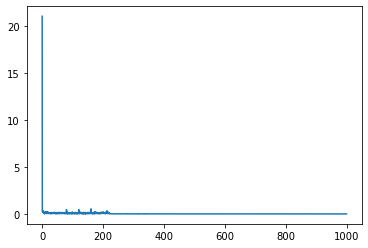

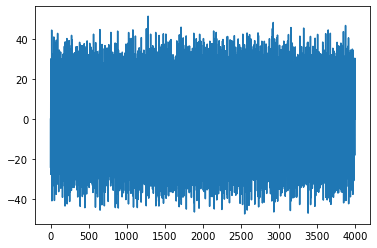

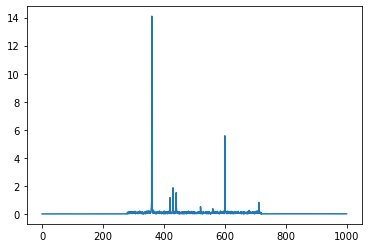

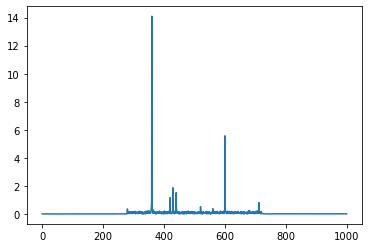

In [34]:
## Example implementations of various filters being used

from scipy.signal import kaiserord,firwin
from scipy import fft

FIR_bandpass = firwin(int(ntaps+1), [70.,180.], fs=desired_sample_rate, window='hamming',pass_zero='bandpass')
FIR_bandstop = firwin(int(ntaps+1), [70.,180.], fs=desired_sample_rate, window='hamming')

NN = eeg_ptsa.shape[2]
xr = np.linspace(0,NN/(4000/sr),NN/2) # 4000 ms of data/500 Hz sampling

## WHAT IS WRONG WITH EEG_RIP?? Nothing! Just hilbert+rectification ruins the bandpass in the FFT

# plot FFT of kaiser 40 hz lowpass
temp_rip = eeg_ptsa[0][0]-8650+1500
filt_temp_rip = filtfilt(kaiser_40lp_filter,1.,temp_rip)
plt.plot(filt_temp_rip); plt.show()
plt.plot(xr,normFFT(filt_temp_rip)); plt.show()

# plot FFT of rectified ripple eeg
temp_rip_band = eeg_rip_band.get_data()[0,0,:]
plt.plot(temp_rip_band); plt.show()
plt.plot(xr,normFFT(temp_rip_band)); plt.show()

# take single trial and filter using Norman FIR filter
temp_eeg = eeg_ptsa[0][0]+8650 # baseline subtracted trial of eeg
temp = filtfilt(FIR_bandpass,1.,temp_eeg)
plt.plot(temp); plt.show()
plt.plot(xr,normFFT(temp)); plt.show();
plt.plot(xr,normFFT(temp_eeg-filtfilt(FIR_bandstop,1.,temp_eeg))); plt.show()

(16, 112, 4000)
raw eeg


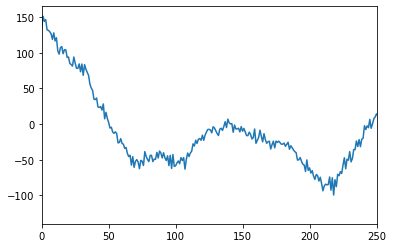

FFT of this trial


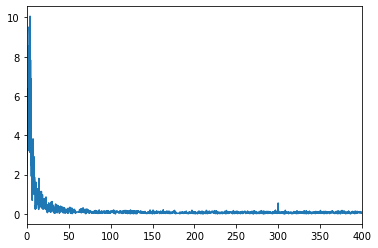

eeg 60 and 180 line removed


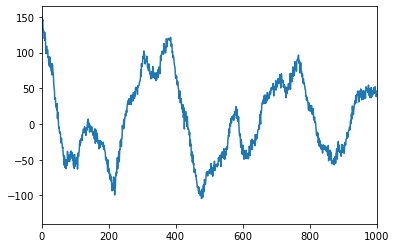

FFT of eeg 60 and 180 removed


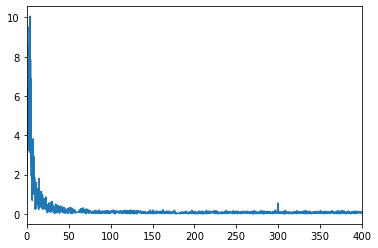

bandpass filtered:


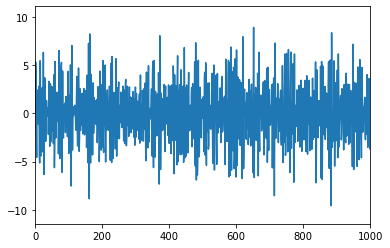

fft after bandpass (looks weird probably needs diff treatment)


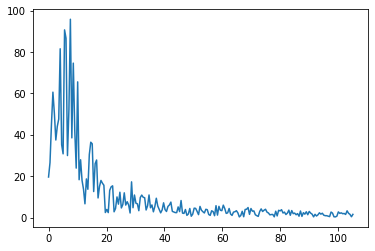

In [239]:
# sub R1151E has some weird-looking EEG. want to investigate what bands are causing this

from scipy.signal import kaiserord,firwin
from scipy import fft
from ptsa.data.filters import ButterworthFilter

trial = 3
channel = 85

bands = [70.,175.]
FIR_bandpass = firwin(int(ntaps+1), bands, fs=desired_sample_rate, window='hamming',pass_zero='bandpass')


print(eeg_ptsa.shape)
temp_rip = eeg_ptsa[trial][channel] # get single trial
NN = eeg_ptsa.shape[2]
xr = np.linspace(0,NN/(8000/1000),NN/2) # 4000 ms of data/500 Hz sampling

print('raw eeg')
plt.plot(temp_rip); plt.xlim((0,250)); plt.show()
print('FFT of this trial')
plt.plot(xr,normFFT(temp_rip)); plt.xlim((0,400)); plt.show()

# filter out 120 Hz?
eeg_120_removed = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
eeg_180_removed = ButterworthFilter(timeseries=eeg_120_removed, freq_range=[178.,182.], filt_type='stop', order=4).filter()
eeg_180_removed = eeg_180_removed[trial][channel]
print('eeg 60 and 180 line removed')
plt.plot(eeg_180_removed); plt.xlim((0,1000)); plt.show()
print('FFT of eeg 60 and 180 removed')
plt.plot(xr,normFFT(eeg_180_removed)); plt.xlim((0,400)); plt.show()

# take single trial and filter using Norman FIR filter
filt_eeg_rip = filtfilt(FIR_bandpass,1.,temp_rip)
print('bandpass filtered:')
plt.plot(filt_eeg_rip); plt.xlim((0,1000)); plt.show()
print('fft after bandpass (looks weird probably needs diff treatment)')
N = int(len(temp_rip)/(1000/(bands[1]-bands[0])))
fft_eeg = 1/N*np.abs(fft(temp_rip)[:N//2])
x_fft = np.linspace(0,N/4,N/2)
plt.plot(x_fft,fft_eeg); plt.show();

In [240]:
tal_struct[80]

(91, 92, 'RPHD8-RPHD9', 'rphd.8-rphd.9', False, False, 'D', 'D', (('avg', 'middletemporal', 58.985, -41.195, -7.645), ('avg.dural', 'middletemporal', 58.985, -41.195, -7.645), ('ind', 'middletemporal', 59.35, -24.17, -16.92), ('ind.dural', 'middletemporal', 59.35, -24.17, -16.92), ('nan', 'nan', nan, nan, nan), ('tal', 'None', 59.56525, -36.3991, -1.472605), ('wb', 'Right Cerebral White Matter', nan, nan, nan), ('nan', 'nan', nan, nan, nan), ('nan', 'nan', nan, nan, nan)), [91, 92], 'D', 'RPHD8-RPHD9')

In [232]:
tal_struct[57]

(66, 67, 'RAHD3-RAHD4', 'rahd.3-rahd.4', False, False, 'D', 'D', (('avg', 'None', 31.835, -14.86, -16.49), ('avg.dural', 'None', 31.835, -14.86, -16.49), ('ind', 'None', 32.62, 1.345, -18.39), ('ind.dural', 'None', 32.62, 1.345, -18.39), ('nan', 'nan', nan, nan, nan), ('tal', 'None', 32.3564, -10.74715, -10.80365), ('wb', 'Right Cerebral White Matter', nan, nan, nan), ('nan', 'nan', nan, nan, nan), ('nan', 'nan', nan, nan, nan)), [66, 67], 'D', 'RAHD3-RAHD4')